In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Importing libraries
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, image as mpimg
from tqdm import tqdm
from time import time
from collections import Counter
import random

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, utils, callbacks
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.transform import resize

import re

In [ ]:
# Set up all the paths
main_dir = "/content/drive/MyDrive/ODIR-5K"  # Update with the correct path in your Google Drive
data = pd.read_excel(os.path.join(main_dir, 'data.xlsx'), sheet_name=None)
data = pd.DataFrame(data[list(data.keys())[0]])
data

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,4686,63,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0
3496,4688,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0
3497,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0
3498,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0


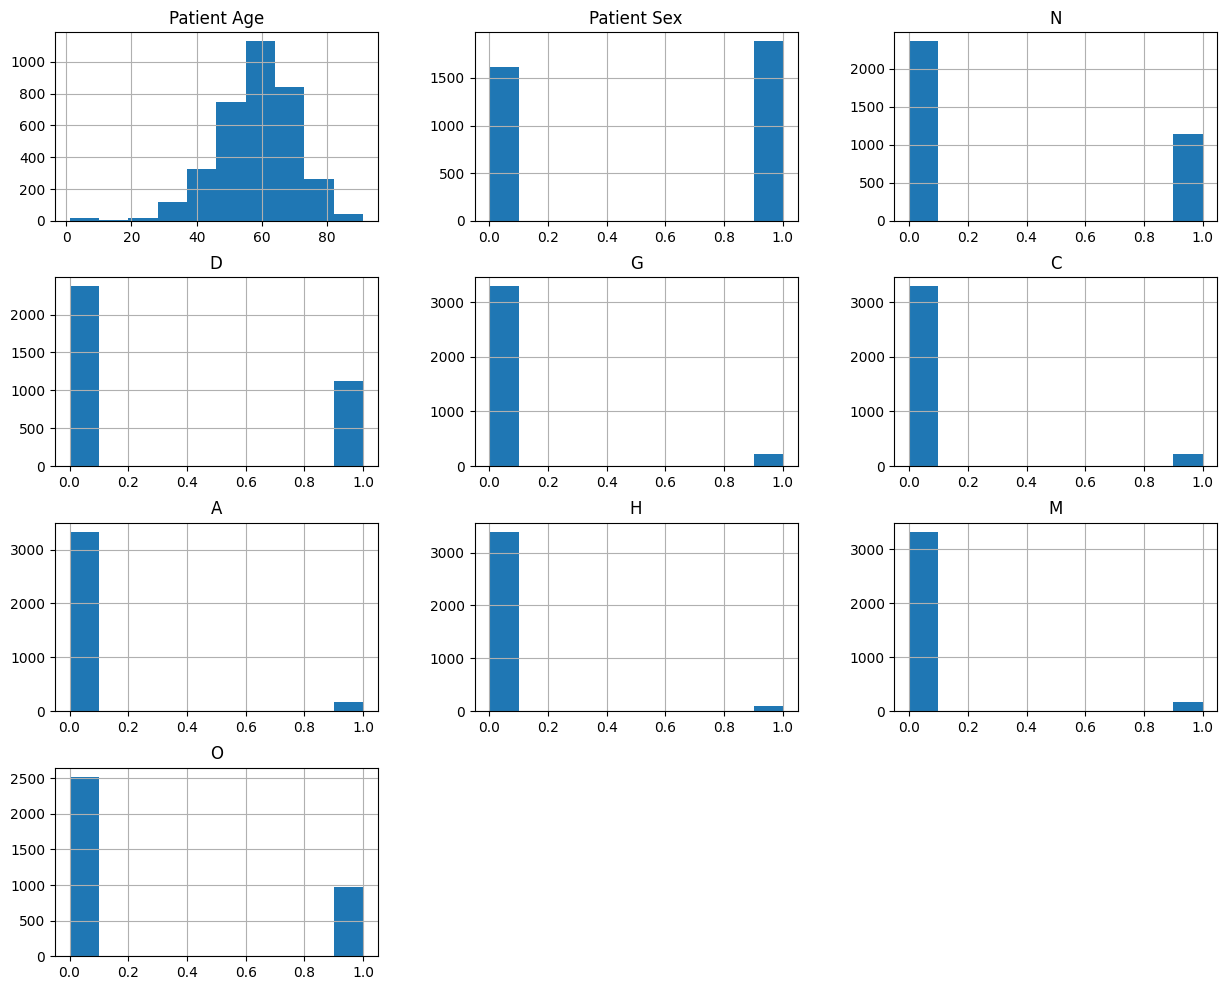

In [ ]:
#Exploratory Data Analysis
data_num = data.copy()[['Patient Age', 'Patient Sex', 'N', 'D','G','C','A','H','M','O']]
data_num['Patient Sex'] = data_num['Patient Sex'].apply(lambda x:0  if x=='Female' else 1) # we encode sex: Female => 0; Male => 1

data_num.hist(figsize=(15,12))

plt.show()

In [ ]:
#data corelations
data_num_corr = data_num.corr()
data_num_corr

,Patient Age,Patient Sex,N,D,G,C,A,H,M,O
Patient Age,1.000000,-0.087703,-0.073049,-0.080539,0.097791,0.186160,0.058005,-0.024944,-0.013635,0.067764
Patient Sex,-0.087703,1.000000,0.035501,0.027582,0.021977,-0.060492,-0.000883,0.032309,-0.078345,-0.036086
N,-0.073049,0.035501,1.000000,-0.479285,-0.177807,-0.176481,-0.154101,-0.121023,-0.158968,-0.433113
D,-0.080539,0.027582,-0.479285,1.000000,-0.094946,-0.075154,-0.106614,0.042701,-0.104288,-0.017049
G,0.097791,0.021977,-0.177807,-0.094946,1.000000,-0.049996,0.005212,0.011778,-0.020193,-0.029528
C,0.186160,-0.060492,-0.176481,-0.075154,-0.049996,1.000000,-0.056300,-0.030041,-0.058079,-0.075515
A,0.058005,-0.000883,-0.154101,-0.106614,0.005212,-0.056300,1.000000,-0.006610,-0.032053,-0.089978
H,-0.024944,0.032309,-0.121023,0.042701,0.011778,-0.030041,-0.006610,1.000000,-0.039828,-0.063315
M,-0.013635,-0.078345,-0.158968,-0.104288,-0.020193,-0.058079,-0.032053,-0.039828,1.000000,-0.013677
O,0.067764,-0.036086,-0.433113,-0.017049,-0.029528,-0.075515,-0.089978,-0.063315,-0.013677,1.000000


In [ ]:
cutoff = .08
data_disease_corr = data_num_corr.iloc[3:,3:].copy() # we cut off everything, except the information about correlation between specific conditions
data_disease_corr = data_disease_corr.applymap(lambda x:np.NaN if abs(x)<cutoff or x==1 else x ).round(2) # we set a cutoff point at .08 and round data to the second decimal point
data_disease_corr

,D,G,C,A,H,M,O
D,NaN,-0.09,NaN,-0.11,NaN,-0.1,NaN
G,-0.09,NaN,NaN,NaN,NaN,NaN,NaN
C,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A,-0.11,NaN,NaN,NaN,NaN,NaN,-0.09
H,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M,-0.10,NaN,NaN,NaN,NaN,NaN,NaN
O,NaN,NaN,NaN,-0.09,NaN,NaN,NaN


In [ ]:
#how many of our patients have more than one disease diagnosed
data_diseases = data.iloc[:,-7:].copy() # a slice of data containing only information about diseases occuring in each patient
disease_counter = Counter()
for i, row in data_diseases.iterrows():
    disease_counter[row.sum()]+=1
disease_counter

Counter({1: 1774, 0: 1140, 2: 557, 3: 29})

In [ ]:
#create a dictionary to store information about keyphrases used in the diagnosis for each disease and the frequency of their usage
conditions = list(data.columns[-8:])
conditions_keyphrases = {condition: Counter() for condition in conditions}

for i, row in data.iterrows():
    # Keyphrases used in the diagnosis for each eye:
    keyphrases = list(set(row['Left-Diagnostic Keywords'].replace('，',',').split(',') + row['Right-Diagnostic Keywords'].replace('，',',').split(',')))

    # For every condition diagnosed
    for condition in conditions:
        if row[condition]==1:
            # Add 1 to the counter for the keyphrases present
            for keyphrase in keyphrases:
                conditions_keyphrases[condition][keyphrase] += 1

# Sort the dictionary for each condition in the descending order:
def dicsort(d):
    d_items_rev = [ (value, key) for (key, value) in d.items() ]
    d_items_sorted = [ (key, value) for (value, key) in sorted(d_items_rev, reverse=True) ]
    d_sorted = {key: value for (key, value) in d_items_sorted}
    return d_sorted

conditions_keyphrases = {condition: dicsort(conditions_keyphrases[condition]) for condition in conditions_keyphrases.keys()}

conditions_keyphrases

{'N': {'normal fundus': 1139, 'lens dust': 136, 'low image quality': 2},
 'D': {'moderate non proliferative retinopathy': 662,
  'mild nonproliferative retinopathy': 456,
  'normal fundus': 257,
  'severe nonproliferative retinopathy': 101,
  'macular epiretinal membrane': 61,
  'epiretinal membrane': 59,
  'laser spot': 54,
  'hypertensive retinopathy': 45,
  'cataract': 39,
  'lens dust': 35,
  'diabetic retinopathy': 33,
  'myelinated nerve fibers': 29,
  'drusen': 26,
  'proliferative diabetic retinopathy': 20,
  'glaucoma': 20,
  'vitreous degeneration': 19,
  'pathological myopia': 18,
  'low image quality': 16,
  'white vessel': 13,
  'suspected glaucoma': 12,
  'severe proliferative diabetic retinopathy': 10,
  'post retinal laser surgery': 9,
  'dry age-related macular degeneration': 9,
  'branch retinal vein occlusion': 8,
  'wet age-related macular degeneration': 6,
  'spotted membranous change': 6,
  'refractive media opacity': 5,
  'epiretinal membrane over the macula': 5,

In [ ]:
conditions_keyphrases_metadata_1 = {
    'n_keyphrases': {condition: len(conditions_keyphrases[condition]) for condition in conditions_keyphrases.keys()},
    'n_occurences': {condition: np.sum(list(conditions_keyphrases[condition].values())) for condition in conditions_keyphrases.keys()}
}

conditions_keyphrases_metadata_1

{'n_keyphrases': {'N': 3,
  'D': 62,
  'G': 39,
  'C': 20,
  'A': 22,
  'H': 23,
  'M': 27,
  'O': 91},
 'n_occurences': {'N': 1277,
  'D': 2085,
  'G': 400,
  'C': 373,
  'A': 259,
  'H': 178,
  'M': 298,
  'O': 2150}}

In [ ]:
conditions_keyphrases = {condition: Counter() for condition in conditions}

for i, row in data.iterrows():
    # If there was only one condition diagnosed, ('N' included) which one is it?
    if row.iloc[-8:].sum()==1:
        condition = row.index[len(row.index)-8 + row.iloc[-8:].astype(np.int32).argmax()]
        # Keyphrases used in the diagnosis for each eye
        keyphrases_L = row['Left-Diagnostic Keywords'].replace('，',',').split(',')
        keyphrases_R = row['Right-Diagnostic Keywords'].replace('，',',').split(',')
        keyphrases = []
        # If this patient was not diagnosed as healthy
        if condition!='N':
            # If this eye was not diagnosed as healthy, add its diagnostic keyphrases to the list of keyphrases
            if 'normal fundus' not in keyphrases_L:
                keyphrases += keyphrases_L
            if 'normal fundus' not in keyphrases_R:
                keyphrases += keyphrases_R
        # If this patient was diagnosed as healthy, then both of his eyes should be ascribed to category 'N'
        else:
            keyphrases += keyphrases_L + keyphrases_R

        # Add the keyphrases to the conditions_keyphrases dictionary:
        for keyphrase in keyphrases:
            conditions_keyphrases[condition][keyphrase] += 1


conditions_keyphrases = {condition: dicsort(conditions_keyphrases[condition]) for condition in conditions_keyphrases.keys()}

conditions_keyphrases_metadata_2 = {
    'n_keyphrases': {condition: len(conditions_keyphrases[condition]) for condition in conditions_keyphrases.keys()},
    'n_occurences': {condition: np.sum(list(conditions_keyphrases[condition].values())) for condition in conditions_keyphrases.keys()}
}

In [ ]:
print('\tInclusive, cross-pollination-prone method:')
print('n_keyphrases:')
print(conditions_keyphrases_metadata_1['n_keyphrases'])
print('n_occurences:')
print(conditions_keyphrases_metadata_1['n_occurences'])

print('\n')

print('\tExclusive, cross-pollination-resistant method:')
print('n_keyphrases:')
print(conditions_keyphrases_metadata_2['n_keyphrases'])
print('n_occurences:')
print(conditions_keyphrases_metadata_2['n_occurences'])

	Inclusive, cross-pollination-prone method:
n_keyphrases:
{'N': 3, 'D': 62, 'G': 39, 'C': 20, 'A': 22, 'H': 23, 'M': 27, 'O': 91}
n_occurences:
{'N': 1277, 'D': 2085, 'G': 400, 'C': 373, 'A': 259, 'H': 178, 'M': 298, 'O': 2150}


	Exclusive, cross-pollination-resistant method:
n_keyphrases:
{'N': 3, 'D': 9, 'G': 4, 'C': 2, 'A': 2, 'H': 1, 'M': 5, 'O': 55}
n_occurences:
{'N': 2502, 'D': 1189, 'G': 204, 'C': 256, 'A': 216, 'H': 72, 'M': 193, 'O': 756}


In [ ]:
conditions_keyphrases

{'N': {'normal fundus': 2277, 'lens dust': 222, 'low image quality': 3},
 'D': {'moderate non proliferative retinopathy': 624,
  'mild nonproliferative retinopathy': 383,
  'severe nonproliferative retinopathy': 142,
  'low image quality': 16,
  'proliferative diabetic retinopathy': 14,
  'severe proliferative diabetic retinopathy': 4,
  'diabetic retinopathy': 4,
  'optic disk photographically invisible': 1,
  'no fundus image': 1},
 'G': {'glaucoma': 184,
  'suspected glaucoma': 14,
  'optic disk photographically invisible': 3,
  'lens dust': 3},
 'C': {'cataract': 235, 'lens dust': 21},
 'A': {'dry age-related macular degeneration': 182,
  'wet age-related macular degeneration': 34},
 'H': {'hypertensive retinopathy': 72},
 'M': {'pathological myopia': 182,
  'myopic retinopathy': 4,
  'lens dust': 4,
  'myopic maculopathy': 2,
  'anterior segment image': 1},
 'O': {'drusen': 130,
  'macular epiretinal membrane': 120,
  'epiretinal membrane': 110,
  'myelinated nerve fibers': 58,
  

In [ ]:
# A dictionary which will contain a frequency of keyphrases occuring within each condition (i.e. what fraction of cases within each condition had a given keyphrase)
conditions_keyphrases_freq = conditions_keyphrases.copy()
for condition in conditions_keyphrases_freq:
    for keyphrase in conditions_keyphrases_freq[condition]:
        conditions_keyphrases_freq[condition][keyphrase] = 0

conditions_counter = Counter() # Counter for number of individual images displaying signs of each condition

for i, row in data.iterrows():
    keyphrases_L = row['Left-Diagnostic Keywords'].replace('，',',').split(',')
    keyphrases_R = row['Right-Diagnostic Keywords'].replace('，',',').split(',')
    for condition in conditions:
        # If at least one eye of this patient has the following condition
        if row[condition]==1:
            # If any keyphrase characteristic of this condition was found in the diagnostic keyphrases for the left eye...
            if any (keyphrase in keyphrases_L for keyphrase in conditions_keyphrases_freq[condition]):
                # ...then we can assume that this eye displays symptoms of this condition. We add 1 to the counter for cases of this condition.
                conditions_counter[condition] += 1
                # For any keyphrase used to describe it...
                for keyphrase in keyphrases_L:
                    # ...we check if it is associated with this condition. If it is, we add 1 to the counter for occurences of keyphrases for this condition.
                    if keyphrase in conditions_keyphrases_freq[condition]:
                        conditions_keyphrases_freq[condition][keyphrase] += 1
            # We repeat the same for the right eye:
            if any (keyphrase in keyphrases_R for keyphrase in conditions_keyphrases_freq[condition]):
                conditions_counter[condition] += 1
                for keyphrase in keyphrases_R:
                    if keyphrase in conditions_keyphrases_freq[condition]:
                        conditions_keyphrases_freq[condition][keyphrase] += 1

# To obtain percentages, we divide each keyphrase count by the number of cases of the condition (i.e. individual eyes displaying characteristic symptoms)
for condition in conditions_keyphrases_freq:
    for keyphrase in conditions_keyphrases_freq[condition]:
        conditions_keyphrases_freq[condition][keyphrase] = np.round(conditions_keyphrases_freq[condition][keyphrase]/conditions_counter[condition], 3)

# Sorting:
conditions_keyphrases_freq = {condition: dicsort(conditions_keyphrases_freq[condition]) for condition in conditions_keyphrases_freq}

conditions_keyphrases_freq

{'N': {'normal fundus': 0.999, 'lens dust': 0.097, 'low image quality': 0.001},
 'D': {'moderate non proliferative retinopathy': 0.55,
  'mild nonproliferative retinopathy': 0.304,
  'severe nonproliferative retinopathy': 0.089,
  'diabetic retinopathy': 0.031,
  'proliferative diabetic retinopathy': 0.014,
  'low image quality': 0.009,
  'severe proliferative diabetic retinopathy': 0.006,
  'optic disk photographically invisible': 0.001,
  'no fundus image': 0.001},
 'G': {'glaucoma': 0.832,
  'suspected glaucoma': 0.13,
  'lens dust': 0.065,
  'optic disk photographically invisible': 0.012},
 'C': {'cataract': 0.966, 'lens dust': 0.111},
 'A': {'dry age-related macular degeneration': 0.823,
  'wet age-related macular degeneration': 0.177},
 'H': {'hypertensive retinopathy': 1.0},
 'M': {'pathological myopia': 0.961,
  'lens dust': 0.027,
  'myopic retinopathy': 0.016,
  'myopic maculopathy': 0.012,
  'anterior segment image': 0.008},
 'O': {'macular epiretinal membrane': 0.162,
  'ep

In [ ]:
all_keyphrases = []
for condition in conditions:
    all_keyphrases += [keyphrase for keyphrase in conditions_keyphrases_freq[condition] if keyphrase not in all_keyphrases]

keyphrases_from_columns = []
for keyphrases_L, keyphrases_R in zip(data['Left-Diagnostic Keywords'].values, data['Right-Diagnostic Keywords'].values):
    keyphrases_from_columns += [keyphrase for keyphrase in keyphrases_L.replace('，',',').split(',') if keyphrase not in keyphrases_from_columns]
    keyphrases_from_columns += [keyphrase for keyphrase in keyphrases_R.replace('，',',').split(',') if keyphrase not in keyphrases_from_columns]

len(all_keyphrases), len(keyphrases_from_columns)

(74, 102)

In [ ]:
def make_keyphrases_df():
    keyphrases_df = pd.DataFrame( {keyphrase: {condition: 0 for condition in conditions} for keyphrase in keyphrases_from_columns} ).T
    keyphrases_df['Predictive power'] = 0 # Predictive power - how many occurrences of this keyphrase were associated with the most frequent class
    return keyphrases_df

keyphrases_excl = make_keyphrases_df()
keyphrases_incl = make_keyphrases_df()
keyphrases_incl

,N,D,G,C,A,H,M,O,Predictive power
cataract,0,0,0,0,0,0,0,0,0
normal fundus,0,0,0,0,0,0,0,0,0
laser spot,0,0,0,0,0,0,0,0,0
moderate non proliferative retinopathy,0,0,0,0,0,0,0,0,0
branch retinal artery occlusion,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
suspected cataract,0,0,0,0,0,0,0,0,0
post retinal laser surgery,0,0,0,0,0,0,0,0,0
age-related macular degeneration,0,0,0,0,0,0,0,0,0
intraretinal microvascular abnormality,0,0,0,0,0,0,0,0,0


In [ ]:
# We reinitialize both DataFrames to avoid errors
keyphrases_excl = make_keyphrases_df()
keyphrases_incl = make_keyphrases_df()

for i, row in data.iterrows():
    # 1.
    only_one_condition = bool(row[-8:].sum()==1)
    # 2.
    keyphrases_L = row['Left-Diagnostic Keywords'].replace('，',',').split(',')
    keyphrases_R = row['Right-Diagnostic Keywords'].replace('，',',').split(',')
    for condition in conditions:
        # 3.
        if row[condition]==1:
            # Left eye
            if any(keyphrase in keyphrases_L for keyphrase in conditions_keyphrases[condition]):
                for keyphrase in keyphrases_L:
                    # 3.1.
                    keyphrases_incl.loc[keyphrase, condition] += 1
                    # 3.2.
                    if only_one_condition:
                        keyphrases_excl.loc[keyphrase, condition] += 1
            # Right eye:
            if any(keyphrase in keyphrases_R for keyphrase in conditions_keyphrases[condition]):
                for keyphrase in keyphrases_R:
                    # 3.1.
                    keyphrases_incl.loc[keyphrase, condition] += 1
                    # 3.2.
                    if only_one_condition:
                        keyphrases_excl.loc[keyphrase, condition] += 1


keyphrases_excl['Predictive power'] = (keyphrases_excl.max(axis=1) / keyphrases_excl.sum(axis=1)).replace(np.NaN, 0)
keyphrases_incl['Predictive power'] = (keyphrases_incl.max(axis=1) / keyphrases_incl.sum(axis=1)).replace(np.NaN, 0)

In [ ]:
keyphrases_excl

,N,D,G,C,A,H,M,O,Predictive power
cataract,0,0,0,235,0,0,0,0,1.000000
normal fundus,2277,0,3,9,0,0,1,43,0.975997
laser spot,0,0,0,0,0,0,0,9,1.000000
moderate non proliferative retinopathy,0,624,0,0,0,0,0,0,1.000000
branch retinal artery occlusion,0,0,0,0,0,0,0,3,1.000000
...,...,...,...,...,...,...,...,...,...
suspected cataract,0,0,0,0,0,0,0,0,0.000000
post retinal laser surgery,0,0,0,0,0,0,0,2,1.000000
age-related macular degeneration,0,0,0,0,0,0,0,0,0.000000
intraretinal microvascular abnormality,0,0,0,0,0,0,0,0,0.000000


In [ ]:
keyphrases_specificity = pd.DataFrame(
    np.zeros(shape=(len(all_keyphrases), 6)),
    index = all_keyphrases,
    columns = ['condition (excl.)','specificity (excl.)', 'condition (incl.)', 'specificity (incl.)', 'condition specificity agreement','specificity discrepancy'],
    dtype='object'
)

for keyphrase, row in keyphrases_specificity.iterrows():
    row.iloc[0] = conditions[keyphrases_excl.loc[keyphrase,:].argmax()]
    row.iloc[1] = keyphrases_excl.loc[keyphrase, 'Predictive power']
    row.iloc[2] = conditions[keyphrases_incl.loc[keyphrase,:].argmax()]
    row.iloc[3] = keyphrases_incl.loc[keyphrase, 'Predictive power']
    row.iloc[4] = row.iloc[0]==row.iloc[2]
    row.iloc[5] = row.iloc[1]-row.iloc[3]
keyphrases_specificity

,condition (excl.),specificity (excl.),condition (incl.),specificity (incl.),condition specificity agreement,specificity discrepancy
normal fundus,N,0.975997,N,0.973077,True,0.00292
lens dust,N,0.639769,N,0.497758,True,0.142012
low image quality,D,0.761905,D,0.761905,True,0.0
moderate non proliferative retinopathy,D,1.0,D,0.799519,True,0.200481
mild nonproliferative retinopathy,D,1.0,D,0.86385,True,0.13615
...,...,...,...,...,...,...
optic discitis,O,1.0,O,1.0,True,0.0
macular coloboma,O,1.0,O,1.0,True,0.0
congenital choroidal coloboma,O,1.0,O,1.0,True,0.0
asteroid hyalosis,O,1.0,O,1.0,True,0.0


In [ ]:

keyphrases_incl.loc['normal fundus']

N                   2277.000000
D                      0.000000
G                      4.000000
C                      9.000000
A                      0.000000
H                      0.000000
M                      1.000000
O                     49.000000
Predictive power       0.973077
Name: normal fundus, dtype: float64

In [ ]:
suspicious_rows = []
for i, row in data.query('G==1 or C==1 or M==1 or O==1').iterrows():
    # 1.
    only_one_condition = bool(row[-8:].sum()==1)
    # 2.
    keyphrases_L = row['Left-Diagnostic Keywords'].replace('，',',').split(',')
    keyphrases_R = row['Right-Diagnostic Keywords'].replace('，',',').split(',')
    if ('normal fundus' in keyphrases_L and len(keyphrases_L)!=1) or ('normal fundus' in keyphrases_R and len(keyphrases_R)!=1):
        suspicious_rows.append(row)


suspicious_rows = pd.DataFrame(suspicious_rows)
suspicious_rows

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
20,20,64,Female,20_left.jpg,20_right.jpg,rhegmatogenous retinal detachment,lens dust，normal fundus,0,0,0,0,0,0,0,1
36,36,55,Male,36_left.jpg,36_right.jpg,lens dust，spotted membranous change,lens dust，normal fundus,0,0,0,0,0,0,0,1
57,57,64,Male,57_left.jpg,57_right.jpg,lens dust，normal fundus,lens dust，drusen，normal fundus,0,0,0,0,0,0,0,1
70,70,57,Female,70_left.jpg,70_right.jpg,epiretinal membrane，lens dust,lens dust，normal fundus,0,0,0,0,0,0,0,1
80,80,50,Female,80_left.jpg,80_right.jpg,lens dust，normal fundus,lens dust，myelinated nerve fibers,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1600,2139,71,Male,2139_left.jpg,2139_right.jpg,lens dust，normal fundus,cataract,0,0,0,1,0,0,0,0
1619,2159,53,Male,2159_left.jpg,2159_right.jpg,cataract,lens dust，normal fundus,0,0,0,1,0,0,0,0
1637,2177,87,Male,2177_left.jpg,2177_right.jpg,normal fundus，lens dust,cataract,0,0,0,1,0,0,0,0
1665,2208,62,Male,2208_left.jpg,2208_right.jpg,normal fundus，lens dust,cataract,0,0,0,1,0,0,0,0


In [ ]:
for condition in conditions:
    print(condition, 'lens dust' in conditions_keyphrases[condition].keys())

N True
D False
G True
C True
A False
H False
M True
O True


In [ ]:
keyphrases_specificity.loc['lens dust']

condition (excl.)                         N
specificity (excl.)                0.639769
condition (incl.)                         N
specificity (incl.)                0.497758
condition specificity agreement        True
specificity discrepancy            0.142012
Name: lens dust, dtype: object

In [ ]:
keyphrases_incl.loc['lens dust']

N                   222.000000
D                    22.000000
G                    22.000000
C                    36.000000
A                     0.000000
H                     0.000000
M                     7.000000
O                   137.000000
Predictive power      0.497758
Name: lens dust, dtype: float64

In [ ]:
keyphrases_O = keyphrases_incl.copy().loc[list(conditions_keyphrases['O'].keys())]
keyphrases_O['O-fraction'] = keyphrases_O['O'] / data['O'].sum()
keyphrases_O['non-O'] = 0

for i, row in data.query('O!=1').iterrows():
    keyphrases_L = row['Left-Diagnostic Keywords'].replace('，',',').split(',')
    keyphrases_R = row['Right-Diagnostic Keywords'].replace('，',',').split(',')
    for keyphrase in keyphrases_O.index:
        if keyphrase in keyphrases_L or keyphrase in keyphrases_R:
            keyphrases_O.loc[keyphrase, 'non-O']+=1

keyphrases_O

,N,D,G,C,A,H,M,O,Predictive power,O-fraction,non-O
drusen,0,14,3,1,0,0,0,180,0.909091,0.183861,0
macular epiretinal membrane,0,49,8,0,2,2,0,201,0.767176,0.205312,0
epiretinal membrane,0,47,5,0,0,0,0,187,0.782427,0.191011,0
myelinated nerve fibers,0,21,4,2,0,0,0,99,0.785714,0.101124,0
vitreous degeneration,0,10,1,1,0,0,0,72,0.857143,0.073544,0
lens dust,222,22,22,36,0,0,7,137,0.497758,0.139939,170
refractive media opacity,0,1,4,0,0,0,4,63,0.875000,0.064351,0
spotted membranous change,0,3,0,0,0,0,0,30,0.909091,0.030644,0
maculopathy,0,1,1,0,0,1,0,28,0.903226,0.028601,0
retinal pigmentation,0,1,0,0,0,0,0,21,0.954545,0.021450,0


In [ ]:
try:
    keyphrases_O.drop(['lens dust', 'low image quality'], axis=0, inplace=True)
except Exception as e:
    pass
keyphrases_O.sort_values(by='O-fraction', axis=0, inplace=True, ascending=False)
keyphrases_O

,N,D,G,C,A,H,M,O,Predictive power,O-fraction,non-O
macular epiretinal membrane,0,49,8,0,2,2,0,201,0.767176,0.205312,0
epiretinal membrane,0,47,5,0,0,0,0,187,0.782427,0.191011,0
drusen,0,14,3,1,0,0,0,180,0.909091,0.183861,0
myelinated nerve fibers,0,21,4,2,0,0,0,99,0.785714,0.101124,0
laser spot,0,78,3,3,0,0,0,95,0.530726,0.097038,0
vitreous degeneration,0,10,1,1,0,0,0,72,0.857143,0.073544,0
refractive media opacity,0,1,4,0,0,0,4,63,0.875000,0.064351,0
spotted membranous change,0,3,0,0,0,0,0,30,0.909091,0.030644,0
tessellated fundus,0,1,1,0,0,0,0,29,0.935484,0.029622,0
maculopathy,0,1,1,0,0,1,0,28,0.903226,0.028601,0


In [ ]:
keyphrases_O['O-fraction'].sum()

1.2655771195097032

In [ ]:
keyphrases_O_chosen = list(keyphrases_O.iloc[:20].index)
print(keyphrases_O.iloc[:20,-2].sum()) # O-fraction is the penultimate column

1.1756894790602659


In [ ]:
diagnostic_keyphrases = {
    'N' : ['normal fundus'],
    'D' : ['nonproliferative retinopathy', 'non proliferative retinopathy', 'proliferative retinopathy'],
    'G' : ['glaucoma'],
    'C' : ['cataract'],
    'A' : ['age-related macular degeneration'],
    'H' : ['hypertensive'],
    'M' : ['myopi'],
    'O' : keyphrases_O_chosen
}

In [ ]:
keyphrases_excl_new = make_keyphrases_df()
keyphrases_incl_new = make_keyphrases_df()

for i, row in data.iterrows():
    # 1.
    only_one_condition = bool(row[-8:].sum()==1)
    # 2.
    keyphrases_L = row['Left-Diagnostic Keywords'].replace('，',',').split(',')
    keyphrases_R = row['Right-Diagnostic Keywords'].replace('，',',').split(',')
    for condition in conditions:
        # 3.
        if row[condition]==1:
            # Left eye
            if any(keyphrase in keyphrases_L for keyphrase in diagnostic_keyphrases[condition]):
                for keyphrase in keyphrases_L:
                    # 3.1.
                    keyphrases_incl_new.loc[keyphrase, condition] += 1
                    # 3.2.
                    if only_one_condition:
                        keyphrases_excl_new.loc[keyphrase, condition] += 1
            # Right eye:
            if any(keyphrase in keyphrases_R for keyphrase in diagnostic_keyphrases[condition]):
                for keyphrase in keyphrases_R:
                    # 3.1.
                    keyphrases_incl_new.loc[keyphrase, condition] += 1
                    # 3.2.
                    if only_one_condition:
                        keyphrases_excl_new.loc[keyphrase, condition] += 1


keyphrases_excl_new['Predictive power'] = (keyphrases_excl_new.max(axis=1) / keyphrases_excl_new.sum(axis=1)).replace(np.NaN, 0)
keyphrases_incl_new['Predictive power'] = (keyphrases_incl_new.max(axis=1) / keyphrases_incl_new.sum(axis=1)).replace(np.NaN, 0)

In [ ]:
keyphrases_incl_new.loc['normal fundus']

N                   2277.000000
D                      0.000000
G                      0.000000
C                      0.000000
A                      0.000000
H                      0.000000
M                      0.000000
O                      3.000000
Predictive power       0.998684
Name: normal fundus, dtype: float64

In [ ]:
fundi_images = {condition:[] for condition in conditions}

for i, row in data.iterrows():
    image_L = row['Left-Fundus']
    image_R = row['Right-Fundus']
    if row['N']==1:
        fundi_images['N'] += [image_L, image_R]
        continue

    # This time there is no need for splitting the keyphrases from strings into lists of keyphrases
    keyphrases_L = row['Left-Diagnostic Keywords']
    keyphrases_R = row['Right-Diagnostic Keywords']

    diagnosed_conditions = []
    for condition in conditions[1:]:
        if row[condition]==1:
            diagnosed_conditions.append(condition)

    if 'normal fundus' in keyphrases_L:
        fundi_images['N'].append(image_L)
        for condition in diagnosed_conditions:
            fundi_images[condition].append(image_R)
        continue
    if 'normal fundus' in keyphrases_R:
        fundi_images['N'].append(image_R)
        for condition in diagnosed_conditions:
            fundi_images[condition].append(image_L)
        continue

    for condition in diagnosed_conditions:
        if any(keyphrase in keyphrases_L for keyphrase in diagnostic_keyphrases[condition]):
            fundi_images[condition].append(image_L)
        if any(keyphrase in keyphrases_R for keyphrase in diagnostic_keyphrases[condition]):
            fundi_images[condition].append(image_R)

In [ ]:
for condition in conditions:
    print(condition, len(fundi_images[condition]), data[condition].sum())

N 3100 1140
D 1711 1128
G 326 215
C 313 212
A 280 164
H 193 103
M 268 174
O 1153 979


In [ ]:
np.sum([len(fundi_images[condition]) for condition in conditions])

7344

In [ ]:
fundi_images_rev = {}
for condition in conditions:
    for im in fundi_images[condition]:
        if im not in fundi_images_rev:
            fundi_images_rev[im] = [condition]
        else:
            fundi_images_rev[im] = sorted(fundi_images_rev[im]+[condition])

conditions_correlation = pd.DataFrame(np.zeros(shape=(7,7)), columns=conditions[1:], index=conditions[1:], dtype=np.int32)

for im in fundi_images_rev:
    if len(fundi_images_rev[im])>1:
        for i in range(len(fundi_images_rev[im])):
            for ii in range(len(fundi_images_rev[im])):
                if i!=ii:

                    conditions_correlation.loc[fundi_images_rev[im][i],fundi_images_rev[im][ii]] += 1

conditions_correlation

,D,G,C,A,H,M,O
D,0,20,15,6,56,8,241
G,20,0,2,14,8,8,30
C,15,2,0,0,3,0,8
A,6,14,0,0,5,2,4
H,56,8,3,5,0,0,5
M,8,8,0,2,0,0,4
O,241,30,8,4,5,4,0


In [ ]:
print(data.query('D==1 & O==1').index.shape[0])
print(data.query('D==1 & H==1').index.shape[0])
print(data.query('G==1 & O==1').index.shape[0])

303
45
49


In [ ]:
print('Total individual images: ', len(fundi_images_rev))

Total individual images:  6910


In [ ]:
images_per_condition_1 = {}
for condition in conditions:
    images_per_condition_1[condition] = len(fundi_images[condition])
images_per_condition_1


{'N': 3100,
 'D': 1711,
 'G': 326,
 'C': 313,
 'A': 280,
 'H': 193,
 'M': 268,
 'O': 1153}

In [ ]:
keyphrases_O_full = list(keyphrases_O.index)
diagnostic_keyphrases['O'] = keyphrases_O_full

fundi_images = {condition:[] for condition in conditions}

for i, row in data.iterrows():
    image_L = row['Left-Fundus']
    image_R = row['Right-Fundus']
    if row['N']==1:
        fundi_images['N'] += [image_L, image_R]
        continue

    # This time there is no need for splitting the keyphrases from strings into lists of keyphrases
    keyphrases_L = row['Left-Diagnostic Keywords']
    keyphrases_R = row['Right-Diagnostic Keywords']

    diagnosed_conditions = []
    for condition in conditions[1:]:
        if row[condition]==1:
            diagnosed_conditions.append(condition)

    if 'normal fundus' in keyphrases_L:
        fundi_images['N'].append(image_L)
        for condition in diagnosed_conditions:
            fundi_images[condition].append(image_R)
        continue
    if 'normal fundus' in keyphrases_R:
        fundi_images['N'].append(image_R)
        for condition in diagnosed_conditions:
            fundi_images[condition].append(image_L)
        continue

    for condition in diagnosed_conditions:
        if any(keyphrase in keyphrases_L for keyphrase in diagnostic_keyphrases[condition]):
            fundi_images[condition].append(image_L)
        if any(keyphrase in keyphrases_R for keyphrase in diagnostic_keyphrases[condition]):
            fundi_images[condition].append(image_R)

In [ ]:
images_per_condition_2 = {}
for condition in conditions:
    images_per_condition_2[condition] = len(fundi_images[condition])

In [ ]:
print(images_per_condition_1)
print(images_per_condition_2)

{'N': 3100, 'D': 1711, 'G': 326, 'C': 313, 'A': 280, 'H': 193, 'M': 268, 'O': 1153}
{'N': 3100, 'D': 1711, 'G': 326, 'C': 313, 'A': 280, 'H': 193, 'M': 268, 'O': 1186}


In [ ]:
fundi_images_rev = {}
for condition in conditions:
    for im in fundi_images[condition]:
        if im not in fundi_images_rev:
            fundi_images_rev[im] = [condition]
        else:
            fundi_images_rev[im] = sorted(fundi_images_rev[im]+[condition])

conditions_correlation = pd.DataFrame(np.zeros(shape=(7,7)), columns=conditions[1:], index=conditions[1:], dtype=np.int32)

for im in fundi_images_rev:
    if len(fundi_images_rev[im])>1:
        for i in range(len(fundi_images_rev[im])):
            for ii in range(len(fundi_images_rev[im])):
                if i!=ii:
                    conditions_correlation.loc[fundi_images_rev[im][i],fundi_images_rev[im][ii]] += 1

print('Total number of individual images: ', len(fundi_images_rev))
conditions_correlation

Total number of individual images:  6932


,D,G,C,A,H,M,O
D,0,20,15,6,56,8,247
G,20,0,2,14,8,8,34
C,15,2,0,0,3,0,8
A,6,14,0,0,5,2,5
H,56,8,3,5,0,0,6
M,8,8,0,2,0,0,4
O,247,34,8,5,6,4,0


In [ ]:
# First, let's give these two dictionaries less mouthful handles

con2img = fundi_images
img2con = fundi_images_rev

imgdata_columns = ['Image', 'Patient Age', 'Patient Sex', *conditions]
imgdata = []

for i, row in data.iterrows():
    image_L = row['Left-Fundus']
    image_R = row['Right-Fundus']
    if image_L in img2con:
        image_conditions = [int(condition in img2con[image_L]) for condition in conditions]
        imgdata.append([image_L, row['Patient Age'], row['Patient Sex'], *image_conditions])
    if image_R in img2con:
        image_conditions = [int(condition in img2con[image_R]) for condition in conditions]
        imgdata.append([image_R, row['Patient Age'], row['Patient Sex'], *image_conditions])

imgdata = pd.DataFrame(imgdata, columns=imgdata_columns)
imgdata['Patient Sex'] = imgdata['Patient Sex'].apply(lambda x:0  if x=='Female' else 1) # encode sex: 'Female'=>0, 'Male'=>1
imgdata

,Image,Patient Age,Patient Sex,N,D,G,C,A,H,M,O
0,0_left.jpg,69,0,0,0,0,1,0,0,0,0
1,0_right.jpg,69,0,1,0,0,0,0,0,0,0
2,1_left.jpg,57,1,1,0,0,0,0,0,0,0
3,1_right.jpg,57,1,1,0,0,0,0,0,0,0
4,2_left.jpg,42,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
6927,4689_right.jpg,54,1,1,0,0,0,0,0,0,0
6928,4690_left.jpg,57,1,0,1,0,0,0,0,0,0
6929,4690_right.jpg,57,1,0,1,0,0,0,0,0,0
6930,4784_left.jpg,58,1,0,0,0,0,1,1,0,0


In [ ]:
con2img = {condition:[] for condition in conditions}
for i, row in data.iterrows():
    image_L = row['Left-Fundus']
    image_R = row['Right-Fundus']
    if row['N']==1:
        con2img['N'] += [image_L, image_R]
        continue

    keyphrases_L = row['Left-Diagnostic Keywords']
    keyphrases_R = row['Right-Diagnostic Keywords']
    diagnosed_conditions = []
    for condition in conditions[1:]:
        if row[condition]==1:
            diagnosed_conditions.append(condition)

    if 'normal fundus' in keyphrases_L:
        con2img['N'].append(image_L)
        for condition in diagnosed_conditions:
            con2img[condition].append(image_R)
        continue
    if 'normal fundus' in keyphrases_R:
        con2img['N'].append(image_R)
        for condition in diagnosed_conditions:
            con2img[condition].append(image_L)
        continue
    for condition in diagnosed_conditions:
        if any(keyphrase in keyphrases_L for keyphrase in diagnostic_keyphrases[condition]):
            con2img[condition].append(image_L)
        if any(keyphrase in keyphrases_R for keyphrase in diagnostic_keyphrases[condition]):
            con2img[condition].append(image_R)
img2con = {}
for condition in conditions:
    for im in con2img[condition]:
        if im not in img2con:
            img2con[im] = [condition]
        else:
            img2con[im] = sorted(img2con[im]+[condition])

# Sanity check: are the numbers the same as in the previous notebook?
for condition in conditions:
    print(condition, len(con2img[condition]))
print(len(img2con))

N 3100
D 1711
G 326
C 313
A 280
H 193
M 268
O 1186
6932


In [ ]:
imgdata_columns = ['Image', 'Patient Age', 'Patient Sex', *conditions]
imgdata = []

for i, row in data.iterrows():
    image_L = row['Left-Fundus']
    image_R = row['Right-Fundus']
    if image_L in img2con:
        image_conditions = [int(condition in img2con[image_L]) for condition in conditions]
        imgdata.append([image_L, row['Patient Age'], row['Patient Sex'], *image_conditions])
    if image_R in img2con:
        image_conditions = [int(condition in img2con[image_R]) for condition in conditions]
        imgdata.append([image_R, row['Patient Age'], row['Patient Sex'], *image_conditions])

imgdata = pd.DataFrame(imgdata, columns=imgdata_columns)
#imgdata['Patient Sex'] = imgdata['Patient Sex'].apply(lambda x:0  if x=='Female' else 1) # encode sex: 'Female'=>0, 'Male'=>1

imgdata_labels = []
for i, row in imgdata.iterrows():
    row_labels = []
    for condition in conditions:
        if row[condition]==1:
            row_labels.append(condition)
    imgdata_labels.append(row_labels)
imgdata['Labels'] = imgdata_labels
imgdata

,Image,Patient Age,Patient Sex,N,D,G,C,A,H,M,O,Labels
0,0_left.jpg,69,Female,0,0,0,1,0,0,0,0,[C]
1,0_right.jpg,69,Female,1,0,0,0,0,0,0,0,[N]
2,1_left.jpg,57,Male,1,0,0,0,0,0,0,0,[N]
3,1_right.jpg,57,Male,1,0,0,0,0,0,0,0,[N]
4,2_left.jpg,42,Male,0,1,0,0,0,0,0,1,"[D, O]"
...,...,...,...,...,...,...,...,...,...,...,...,...
6927,4689_right.jpg,54,Male,1,0,0,0,0,0,0,0,[N]
6928,4690_left.jpg,57,Male,0,1,0,0,0,0,0,0,[D]
6929,4690_right.jpg,57,Male,0,1,0,0,0,0,0,0,[D]
6930,4784_left.jpg,58,Male,0,0,0,0,1,1,0,0,"[A, H]"


In [ ]:
con2ind = {condition: [] for condition in conditions}
for i, row in imgdata.iterrows():
    for condition in conditions:
        if row[condition]==1:
            con2ind[condition].append(i)
for condition in conditions:
    con2ind[condition] = np.array(con2ind[condition])

print('con2img sizes:')
for condition in conditions:
    print(condition, len(con2img[condition]))

print('\ncon2ind sizes:')
for condition in conditions:
    print(condition, len(con2img[condition]))

con2img sizes:
N 3100
D 1711
G 326
C 313
A 280
H 193
M 268
O 1186

con2ind sizes:
N 3100
D 1711
G 326
C 313
A 280
H 193
M 268
O 1186


original:	 (1536, 2048, 3)


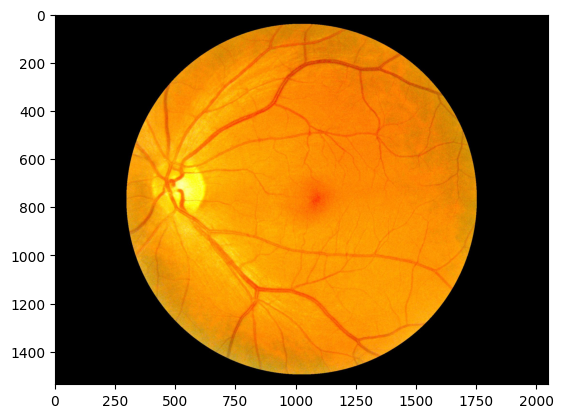

preprocessed:	 (224, 224, 3)


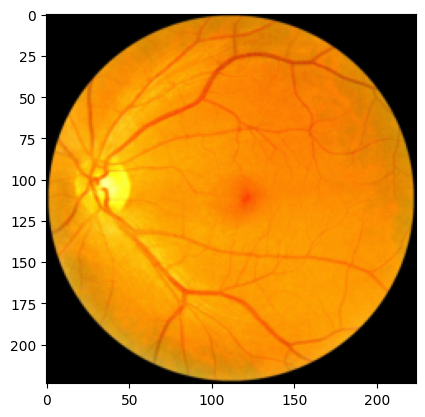

In [ ]:
import os
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define IMG_SIZE
IMG_SIZE = 224  # Replace this with your desired image size
train_dir = "/content/drive/MyDrive/ODIR-5K/Training Images"

def image_prep(image, target_shape=(IMG_SIZE, IMG_SIZE, 3)):
    non_0_rows = np.array([row_idx for row_idx, row in enumerate(image) if np.count_nonzero(row) != 0])
    non_0_cols = np.array([col_idx for col_idx, col in enumerate(image.transpose(1, 0, 2)) if np.count_nonzero(col) != 0])
    image = image[non_0_rows.min():non_0_rows.max() + 1, non_0_cols.min():non_0_cols.max() + 1, :]  # clip
    image = resize(image, target_shape)  # resize
    return image

# TEST:
file_list = os.listdir(train_dir)
if len(file_list) > 0:
    file_path = os.path.join(train_dir, file_list[0])

    if os.path.exists(file_path):
        image = mpimg.imread(file_path)
        print('original:\t', image.shape)
        plt.imshow(image)
        plt.show()

        image_prepped = image_prep(image)
        print('preprocessed:\t', image_prepped.shape)
        plt.imshow(image_prepped)
        plt.show()
    else:
        print(f"File not found: {file_path}")
else:
    print(f"No files found in directory: {train_dir}")

In [ ]:
#We will split the set of 3100 'N' images into training, validation, and test sets with proportions of 8:1:1 (or 2480:310:310), respectively
N_indices = con2ind['N'].copy() # get indices of 'N' images in the imgdata DataFrame
np.random.shuffle(N_indices) # randomly shuffle these indices
N_indices_train, N_indices_val, N_indices_test = N_indices[:2480], N_indices[2480:2790], N_indices[2790:] # split these indices into training, validation, and test set
N_indices_train.shape, N_indices_val.shape, N_indices_test.shape # sanity check

((2480,), (310,), (310,))

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Your image preprocessing function and other code...

# idg template for training and validation data
train_idg = ImageDataGenerator(
    horizontal_flip=True, vertical_flip=True, rotation_range=180,
    rescale=1./255.,
    preprocessing_function=image_prep
)

# idg template for testing data
test_idg = ImageDataGenerator(
    rescale=1./255.,
    preprocessing_function=image_prep
)

# training data generator for age prediction
age_train_generator = train_idg.flow_from_dataframe(
    dataframe = imgdata.iloc[N_indices_train, :],
    directory = train_dir,
    x_col='Image',
    y_col='Patient Age',
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode='raw',
    target_size=(IMG_SIZE, IMG_SIZE)
)
# validation data generator for age prediction
age_val_generator = train_idg.flow_from_dataframe(
    dataframe = imgdata.iloc[N_indices_val, :],
    directory = train_dir,
    x_col='Image',
    y_col='Patient Age',
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode='raw',
    target_size=(IMG_SIZE, IMG_SIZE)
)
# testing data generator for age prediction
age_test_generator = test_idg.flow_from_dataframe(
    dataframe = imgdata.iloc[N_indices_test, :],
    directory = train_dir,
    x_col='Image',
    y_col='Patient Age',
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode='raw',
    target_size=(IMG_SIZE, IMG_SIZE)
)

Found 2480 validated image filenames.
Found 310 validated image filenames.
Found 310 validated image filenames.


In [ ]:
#We import the pre-trained ResNet152 model as the convolutional base and add a densely connected classifier on
#create a model for age prediction. Like Kim et al., we will use Adam optimizer with learning rate of 1e-5 (as well as beta1=0.9 and beta2=0.999, set as default values)
#Huber loss function and MAE as a performance metric.
from tensorflow.keras.applications import ResNet152
from tensorflow.keras import models, layers, optimizers


resnet152 = ResNet152(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
resnet152.trainable = False  # We freeze the weights of the convolutional base

age_model = models.Sequential(name='age_model')
age_model.add(resnet152)
age_model.add(layers.Flatten(name='flatten'))
age_model.add(layers.Dense(1, activation=None, name='dense_output'))

age_model.compile(
    optimizer=optimizers.Adam(lr=1e-5),
    loss='huber',
    metrics=['mae']
)

age_model.summary()

234698864/234698864 [==============================] - 1s 0us/step


Model: "age_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense_output (Dense)        (None, 1)                 100353    
                                                                 
Total params: 58471297 (223.05 MB)
Trainable params: 100353 (392.00 KB)
Non-trainable params: 58370944 (222.67 MB)
_________________________________________________________________


In [ ]:
data = pd.read_excel(os.path.join(main_dir, 'data.xlsx'))
data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


In [ ]:
classes = list(data.columns[7:15])
data['Patient Labels'] = data.apply(lambda x:[class_ for class_ in classes if x[class_]==1], axis=1)
data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,Patient Labels
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,[C]
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,[N]
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,"[D, O]"
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1,[O]
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,"[D, O]"


In [ ]:
# Names of columns in the DataFrame
col_names = ['Image', 'Keywords', 'Age', 'Sex', 'Patient Labels']

# DataFrame for left-eye images
eyes_L = data[['Left-Fundus', 'Left-Diagnostic Keywords', 'Patient Age', 'Patient Sex', 'Patient Labels']]
eyes_L.columns = col_names

# DataFrame for right-eye images
eyes_R = data[['Right-Fundus', 'Right-Diagnostic Keywords', 'Patient Age', 'Patient Sex', 'Patient Labels']]
eyes_R.columns = col_names

# DataFrame for left-eye and right-eye images combined
eyes_df = pd.concat([eyes_L, eyes_R], axis=0)

eyes_df

,Image,Keywords,Age,Sex,Patient Labels
0,0_left.jpg,cataract,69,Female,[C]
1,1_left.jpg,normal fundus,57,Male,[N]
2,2_left.jpg,laser spot，moderate non proliferative retinopathy,42,Male,"[D, O]"
3,3_left.jpg,normal fundus,66,Male,[O]
4,4_left.jpg,macular epiretinal membrane,53,Male,"[D, O]"
...,...,...,...,...,...
3495,4686_right.jpg,proliferative diabetic retinopathy,63,Male,[D]
3496,4688_right.jpg,moderate non proliferative retinopathy,42,Male,[D]
3497,4689_right.jpg,normal fundus,54,Male,[D]
3498,4690_right.jpg,mild nonproliferative retinopathy,57,Male,[D]


In [ ]:
# Keywords characteristic for 'O' class:

O_keywords = [
    'macular epiretinal membrane',
    'epiretinal membrane',
    'drusen',
    #'lens dust',
    'myelinated nerve fibers',
    'laser spot',
    'vitreous degeneration',
    'refractive media opacity',
    'spotted membranous change',
    'tessellated fundus',
    'maculopathy',
    'chorioretinal atrophy',
    'branch retinal vein occlusion',
    'retinal pigmentation',
    'white vessel',
    'post retinal laser surgery',
    'epiretinal membrane over the macula',
    'retinitis pigmentosa',
    'central retinal vein occlusion',
    'optic disc edema',
    'post laser photocoagulation',
    'retinochoroidal coloboma',
    'atrophic change',
    'optic nerve atrophy',
    'old branch retinal vein occlusion',
    'depigmentation of the retinal pigment epithelium',
    'chorioretinal atrophy with pigmentation proliferation',
    'central retinal artery occlusion',
    'old chorioretinopathy',
    'pigment epithelium proliferation',
    'retina fold',
    'abnormal pigment ',
    'idiopathic choroidal neovascularization',
    'branch retinal artery occlusion',
    'vessel tortuosity',
    'pigmentation disorder',
    'rhegmatogenous retinal detachment',
    'macular hole',
    'morning glory syndrome',
    'atrophy',
    #'low image quality',
    'arteriosclerosis',
    'asteroid hyalosis',
    'congenital choroidal coloboma',
    'macular coloboma',
    'optic discitis',
    'oval yellow-white atrophy',
    'wedge-shaped change',
    'wedge white line change',
    'retinal artery macroaneurysm',
    'retinal vascular sheathing',
    'suspected abnormal color of  optic disc',
    'suspected retinal vascular sheathing',
    'suspected retinitis pigmentosa',
    'silicone oil eye',
    'fundus laser photocoagulation spots',
    'glial remnants anterior to the optic disc',
    'intraretinal microvascular abnormality'


]

In [ ]:
def generate_eye_labels(keywords, patient_labels):
    eye_labels = []

    if 'normal fundus' in keywords:
        eye_labels.append('N')
        if list(set(keywords.replace('，', ',').split(',')))==['normal fundus']: # there were two images, for which 'normal fundus' keyphrase was duplicated
            eye_labels.append('N+') # healthy fundus without any caveats (like lens dust or low image quality)
            return eye_labels # in this case we know that there are no other keywords, so we can already quit the function and return the list
        else:
            eye_labels.append('N-') # healthy fundus but with some caveats
    if 'lens dust' in keywords:
        eye_labels.append('LD') # lens dust
    if 'low image quality' in keywords:
        eye_labels.append('LIQ') # low image quality
    if 'D' in patient_labels and ('proliferative retinopathy' in keywords or 'diabetic' in keywords):
        eye_labels.append('D') # diabetes
    if 'suspected glaucoma' in keywords:
        eye_labels.append('SG') # suspected glaucoma (it may be real glaucoma or may not)
    elif 'glaucoma' in keywords:
        eye_labels.append('G') # glaucoma
    if 'hypertensi' in keywords:
        eye_labels.append('H') # hypertension
    if 'O' in patient_labels and (any(O_keyword in keywords for O_keyword in O_keywords)):
        eye_labels.append('O') # other (anything else)
    return eye_labels
eyes_df['Eye Labels'] = eyes_df.apply(lambda x: generate_eye_labels(x['Keywords'], x['Patient Labels']), axis=1)
eyes_df

,Image,Keywords,Age,Sex,Patient Labels,Eye Labels
0,0_left.jpg,cataract,69,Female,[C],[]
1,1_left.jpg,normal fundus,57,Male,[N],"[N, N+]"
2,2_left.jpg,laser spot，moderate non proliferative retinopathy,42,Male,"[D, O]","[D, O]"
3,3_left.jpg,normal fundus,66,Male,[O],"[N, N+]"
4,4_left.jpg,macular epiretinal membrane,53,Male,"[D, O]",[O]
...,...,...,...,...,...,...
3495,4686_right.jpg,proliferative diabetic retinopathy,63,Male,[D],[D]
3496,4688_right.jpg,moderate non proliferative retinopathy,42,Male,[D],[D]
3497,4689_right.jpg,normal fundus,54,Male,[D],"[N, N+]"
3498,4690_right.jpg,mild nonproliferative retinopathy,57,Male,[D],[D]


In [ ]:
c = Counter()
for eye_label in eyes_df['Eye Labels']:
    c[tuple(eye_label)] +=1
c

Counter({(): 752,
         ('N', 'N+'): 2818,
         ('D', 'O'): 251,
         ('O',): 826,
         ('D',): 1429,
         ('D', 'H'): 67,
         ('H',): 112,
         ('G', 'O'): 20,
         ('LD', 'O'): 59,
         ('N', 'N-', 'LD'): 277,
         ('SG',): 20,
         ('G',): 224,
         ('LD', 'D'): 11,
         ('H', 'O'): 6,
         ('SG', 'H'): 2,
         ('LIQ', 'O'): 1,
         ('LD', 'D', 'O'): 9,
         ('LD',): 33,
         ('D', 'SG'): 11,
         ('N', 'N-', 'LD', 'O'): 3,
         ('D', 'G'): 18,
         ('G', 'H'): 6,
         ('SG', 'O'): 9,
         ('D', 'G', 'O'): 3,
         ('LD', 'G'): 8,
         ('LD', 'D', 'G', 'O'): 1,
         ('LIQ',): 20,
         ('LD', 'SG'): 1,
         ('LD', 'D', 'SG'): 1,
         ('LD', 'G', 'O'): 2})

In [ ]:
def extract_dataframe(criteria=['C'], n_max=0, shuffle=True, df=eyes_df):
    if type(criteria)!=type(list()):
        criteria = [criteria]
    disease_criteria = [criterion for criterion in criteria if criterion!='Male' and criterion!='Female']

    if disease_criteria==[]:
        df['extract'] = 1
    else:
        df['extract'] = df['Eye Labels'].apply(lambda x: 1 if all(criterion in x for criterion in disease_criteria) else 0)

    if 'Male' in criteria:
        df['extract'] = df['extract'] * df['Sex'].apply(lambda x: 1 if x=='Male' else 0 )
    elif 'Female' in criteria:
        df['extract'] = df['extract'] * df['Sex'].apply(lambda x: 1 if x=='Female' else 0 )

    extract_df = df.query(' `extract` == 1 ')
    extract_df.drop('extract', axis=1, inplace=True)
    df.drop('extract', axis=1, inplace=True)
    if shuffle:
        extract_df = extract_df.sample(frac=1)
    extract_df.reset_index(drop=True, inplace=True)
    if n_max!=0:
        extract_df = extract_df.iloc[:n_max, :]

    return extract_df

In [ ]:
males_with_cataract_df = extract_dataframe(['C', 'Male'])
print(males_with_cataract_df['Eye Labels'].value_counts()) # Distribution of eye labels in males with cataract
print(males_with_cataract_df['Patient Labels'].value_counts()) # Distribution of patient labels in males with cataract
print(males_with_cataract_df['Sex'].value_counts()) # Distribution of sexes in males with cataract - unsurprisingly boring
males_with_cataract_df

Series([], Name: Eye Labels, dtype: int64)
Series([], Name: Patient Labels, dtype: int64)
Series([], Name: Sex, dtype: int64)


<ipython-input-57-5751524ddef3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_df.drop('extract', axis=1, inplace=True)


,Image,Keywords,Age,Sex,Patient Labels,Eye Labels


In [ ]:
all_eye_labels = [*classes, 'N-', 'N+','LD','LIQ','SG']
for criterion in [*all_eye_labels, 'Male', 'Female']:
    print(criterion, extract_dataframe(criterion).shape[0])

<ipython-input-57-5751524ddef3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_df.drop('extract', axis=1, inplace=True)
<ipython-input-57-5751524ddef3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_df.drop('extract', axis=1, inplace=True)
<ipython-input-57-5751524ddef3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_df.drop('extract', axis=1, inplace=True)
<ipython-input-57-5751524ddef3>:17: SettingWit

N 3098
D 1801
G 282
C 0
A 0
H 193
M 0
O

<ipython-input-57-5751524ddef3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_df.drop('extract', axis=1, inplace=True)
<ipython-input-57-5751524ddef3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_df.drop('extract', axis=1, inplace=True)
<ipython-input-57-5751524ddef3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_df.drop('extract', axis=1, inplace=True)


 1190
N- 280
N+ 2818
LD 405
LIQ 21
SG 44
Male 3770
Female 3230


<ipython-input-57-5751524ddef3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_df.drop('extract', axis=1, inplace=True)
<ipython-input-57-5751524ddef3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_df.drop('extract', axis=1, inplace=True)
<ipython-input-57-5751524ddef3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_df.drop('extract', axis=1, inplace=True)
<ipython-input-57-5751524ddef3>:17: SettingWit

In [ ]:
print("There are %i images of perfectly healthy male eyes in the dataset" % extract_dataframe(['Male','N+']).shape[0])
print("There are %i images of perfectly healthy female eyes in the dataset" % extract_dataframe(['Female', 'N+']).shape[0])
print("There are %i images of perfectly healthy eyes in total in the dataset" % extract_dataframe(['N+']).shape[0])

<ipython-input-57-5751524ddef3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_df.drop('extract', axis=1, inplace=True)
<ipython-input-57-5751524ddef3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_df.drop('extract', axis=1, inplace=True)


There are 1547 images of perfectly healthy male eyes in the dataset
There are 1271 images of perfectly healthy female eyes in the dataset
There are 2818 images of perfectly healthy eyes in total in the dataset


<ipython-input-57-5751524ddef3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_df.drop('extract', axis=1, inplace=True)


Original (raw) image:	 (1536, 2048, 3)


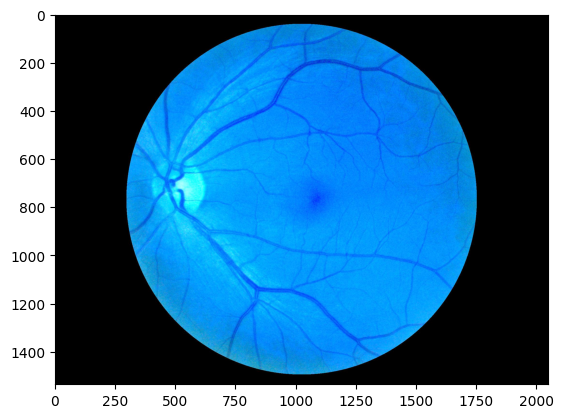

Preprocessed image:	 (1024, 1024, 3)


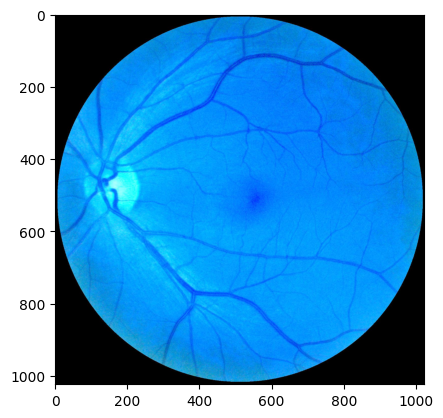

In [ ]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, image as mpimg
from tqdm import tqdm
from time import time
from collections import Counter
import random

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, losses, metrics, utils, callbacks, applications
from sklearn.model_selection import train_test_split as tts
import cv2 as cv

# Image size: 1024px x 1024px (x 3 color (RGB) channels)
IMG_SIZE = 1024
BATCH_SIZE = 32

# Paths to directories

train_dir = '/content/drive/MyDrive/ODIR-5K/Training Images'
test_dir = '/content/drive/MyDrive/ODIR-5K/Testing Images'
main_dir = '/content/drive/MyDrive/ODIR-5K'

history_dir = '/content/drive/MyDrive/working/history'
if not os.path.isdir(history_dir):
    os.mkdir(history_dir)

    models_dir = '/content/drive/MyDrive/working/models'
if not os.path.isdir(models_dir):
    os.mkdir(models_dir)


# A function to load and preprocess image (clip out the black background and resize it properly)

def load_prep_img(image_path, target_shape=(IMG_SIZE, IMG_SIZE)):
    image = cv.imread(image_path, cv.IMREAD_COLOR) # load from the directory
    non_0_rows = np.array([row_idx for row_idx, row in enumerate(image) if np.count_nonzero(row)!=0])
    non_0_cols = np.array([col_idx for col_idx, col in enumerate(image.transpose(1,0,2)) if np.count_nonzero(col)!=0])
    image = image[non_0_rows.min():non_0_rows.max()+1, non_0_cols.min():non_0_cols.max()+1, :] # clip
    image = cv.resize(image, target_shape)
    return image


# Function test:
image_path = os.path.join(train_dir, os.listdir(train_dir)[0])

image = cv.imread(image_path, cv.IMREAD_COLOR)
print('Original (raw) image:\t',image.shape)
plt.imshow(image)
plt.show()

image_prepped = load_prep_img(image_path)
print('Preprocessed image:\t', image_prepped.shape)
plt.imshow(image_prepped)
plt.show()

In [ ]:
data = pd.read_excel(os.path.join(main_dir, 'data.xlsx'))
data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


In [ ]:
classes = list(data.columns[7:15])
data['Patient Labels'] = data.apply(lambda x:[class_ for class_ in classes if x[class_]==1], axis=1)
data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,Patient Labels
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,[C]
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,[N]
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,"[D, O]"
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1,[O]
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,"[D, O]"


In [ ]:
# Names of columns in the DataFrame
col_names = ['Image', 'Keywords', 'Age', 'Sex', 'Patient Labels']

# DataFrame for left-eye images
eyes_L = data[['Left-Fundus', 'Left-Diagnostic Keywords', 'Patient Age', 'Patient Sex', 'Patient Labels']]
eyes_L.columns = col_names

# DataFrame for right-eye images
eyes_R = data[['Right-Fundus', 'Right-Diagnostic Keywords', 'Patient Age', 'Patient Sex', 'Patient Labels']]
eyes_R.columns = col_names

# DataFrame for left-eye and right-eye images combined
eyes_df = pd.concat([eyes_L, eyes_R], axis=0)

eyes_df

,Image,Keywords,Age,Sex,Patient Labels
0,0_left.jpg,cataract,69,Female,[C]
1,1_left.jpg,normal fundus,57,Male,[N]
2,2_left.jpg,laser spot，moderate non proliferative retinopathy,42,Male,"[D, O]"
3,3_left.jpg,normal fundus,66,Male,[O]
4,4_left.jpg,macular epiretinal membrane,53,Male,"[D, O]"
...,...,...,...,...,...
3495,4686_right.jpg,proliferative diabetic retinopathy,63,Male,[D]
3496,4688_right.jpg,moderate non proliferative retinopathy,42,Male,[D]
3497,4689_right.jpg,normal fundus,54,Male,[D]
3498,4690_right.jpg,mild nonproliferative retinopathy,57,Male,[D]


In [ ]:
# Keywords characteristic for 'O' class:

O_keywords = [
    'macular epiretinal membrane',
    'epiretinal membrane',
    'drusen',
    #'lens dust',
    'myelinated nerve fibers',
    'laser spot',
    'vitreous degeneration',
    'refractive media opacity',
    'spotted membranous change',
    'tessellated fundus',
    'maculopathy',
    'chorioretinal atrophy',
    'branch retinal vein occlusion',
    'retinal pigmentation',
    'white vessel',
    'post retinal laser surgery',
    'epiretinal membrane over the macula',
    'retinitis pigmentosa','central retinal vein occlusion',
    'optic disc edema',
    'post laser photocoagulation',
    'retinochoroidal coloboma',
    'atrophic change',
    'optic nerve atrophy',
    'old branch retinal vein occlusion',
    'depigmentation of the retinal pigment epithelium',
    'chorioretinal atrophy with pigmentation proliferation',
    'central retinal artery occlusion',
    'old chorioretinopathy',
    'pigment epithelium proliferation',
    'retina fold',
    'abnormal pigment ',
    'idiopathic choroidal neovascularization',
    'branch retinal artery occlusion',
    'vessel tortuosity',
    'pigmentation disorder',
    'rhegmatogenous retinal detachment',
    'macular hole',
    'morning glory syndrome',
    'atrophy',#'low image quality',
    'arteriosclerosis',
    'asteroid hyalosis',
    'congenital choroidal coloboma',
    'macular coloboma',
    'optic discitis',
    'oval yellow-white atrophy',
    'wedge-shaped change',
    'wedge white line change',
    'retinal artery macroaneurysm',
    'retinal vascular sheathing',
    'suspected abnormal color of  optic disc',
    'suspected retinal vascular sheathing',
    'suspected retinitis pigmentosa',
    'silicone oil eye',
    'fundus laser photocoagulation spots',
    'glial remnants anterior to the optic disc',
    'intraretinal microvascular abnormality'


]

In [ ]:
def generate_eye_labels(keywords, patient_labels):
    eye_labels = []

    if 'normal fundus' in keywords:
        eye_labels.append('N')
        if list(set(keywords.replace('，', ',').split(',')))==['normal fundus']: # there were two images, for which 'normal fundus' keyphrase was duplicated
            eye_labels.append('N+') # healthy fundus without any caveats (like lens dust or low image quality)
            return eye_labels # in this case we know that there are no other keywords, so we can already quit the function and return the list
        else:
            eye_labels.append('N-') # healthy fundus but with some caveats
    if 'lens dust' in keywords:
        eye_labels.append('LD') # lens dust
    if 'low image quality' in keywords:
       eye_labels.append('LIQ') # low image quality
    if 'D' in patient_labels and ('proliferative retinopathy' in keywords or 'diabetic' in keywords):
        eye_labels.append('D') # diabetes
    if 'suspected glaucoma' in keywords:
        eye_labels.append('SG') # suspected glaucoma (it may be real glaucoma or may not)
    elif 'glaucoma' in keywords:
        eye_labels.append('G') # glaucoma
    if 'cataract' in keywords:
        eye_labels.append('C') # cataract
    if 'age-related' in keywords:
        eye_labels.append('A') # AMD
    if 'hypertensi' in keywords:
        eye_labels.append('H') # hypertension
    if 'myopi' in keywords:
        eye_labels.append('M') # myopia
    if 'O' in patient_labels and (any(O_keyword in keywords for O_keyword in O_keywords)):
        eye_labels.append('O') # other (anything else)
    return eye_labels

eyes_df['Eye Labels'] = eyes_df.apply(lambda x: generate_eye_labels(x['Keywords'], x['Patient Labels']), axis=1)
eyes_df

,Image,Keywords,Age,Sex,Patient Labels,Eye Labels
0,0_left.jpg,cataract,69,Female,[C],[C]
1,1_left.jpg,normal fundus,57,Male,[N],"[N, N+]"
2,2_left.jpg,laser spot，moderate non proliferative retinopathy,42,Male,"[D, O]","[D, O]"
3,3_left.jpg,normal fundus,66,Male,[O],"[N, N+]"
4,4_left.jpg,macular epiretinal membrane,53,Male,"[D, O]",[O]
...,...,...,...,...,...,...
3495,4686_right.jpg,proliferative diabetic retinopathy,63,Male,[D],[D]
3496,4688_right.jpg,moderate non proliferative retinopathy,42,Male,[D],[D]
3497,4689_right.jpg,normal fundus,54,Male,[D],"[N, N+]"
3498,4690_right.jpg,mild nonproliferative retinopathy,57,Male,[D],[D]


In [ ]:
c = Counter()
for eye_label in eyes_df['Eye Labels']:
    c[tuple(eye_label)] +=1
c

Counter({('C',): 263,
         ('N', 'N+'): 2818,
         ('D', 'O'): 247,
         ('O',): 814,
         ('D',): 1392,
         ('D', 'H'): 67,
         ('M',): 240,
         ('H',): 104,
         ('G', 'O'): 20,
         ('LD', 'O'): 58,
         ('A',): 238,
         ('N', 'N-', 'LD'): 277,
         ('D', 'C'): 13,
         ('SG',): 18,
         ('G',): 202,
         ('G', 'A'): 14,
         ('LD', 'D'): 11,
         ('D', 'A'): 16,
         ('H', 'O'): 6,
         ('SG', 'H'): 2,
         ('LIQ', 'O'): 1,
         ('LD', 'D', 'O'): 9,
         ('LD', 'C', 'O'): 1,
         (): 9,
         ('LD', 'C'): 24,
         ('SG', 'C'): 2,
         ('A', 'M'): 2,
         ('D', 'SG'): 11,
         ('A', 'O'): 4,
         ('N', 'N-', 'LD', 'O'): 3,
         ('A', 'H'): 5,
         ('G', 'M'): 8,
         ('D', 'G'): 18,
         ('G', 'H'): 6,
         ('SG', 'O'): 9,
         ('D', 'G', 'O'): 3,
         ('LD', 'G'): 8,
         ('M', 'O'): 4,
         ('LD', 'M'): 6,
         ('D', 'M'): 8

In [ ]:
def extract_dataframe(criteria=['C'], n_max=0, shuffle=True, df=eyes_df):
    if type(criteria)!=type(list()):
        criteria = [criteria]
    disease_criteria = [criterion for criterion in criteria if criterion!='Male' and criterion!='Female']

    if disease_criteria==[]:
        df['extract'] = 1
    else:
        df['extract'] = df['Eye Labels'].apply(lambda x: 1 if all(criterion in x for criterion in disease_criteria) else 0)

    if 'Male' in criteria:
        df['extract'] = df['extract'] * df['Sex'].apply(lambda x: 1 if x=='Male' else 0 )
    elif 'Female' in criteria:
        df['extract'] = df['extract'] * df['Sex'].apply(lambda x: 1 if x=='Female' else 0 )

    extract_df = df.query(' `extract` == 1 ')
    extract_df.drop('extract', axis=1, inplace=True)
    df.drop('extract', axis=1, inplace=True)
    if shuffle:
        extract_df = extract_df.sample(frac=1)
    extract_df.reset_index(drop=True, inplace=True)
    if n_max!=0:
        extract_df = extract_df.iloc[:n_max, :]

    return extract_df

In [ ]:
males_with_cataract_df = extract_dataframe(['C', 'Male'])
print(males_with_cataract_df['Eye Labels'].value_counts()) # Distribution of eye labels in males with cataract
print(males_with_cataract_df['Patient Labels'].value_counts()) # Distribution of patient labels in males with cataract
print(males_with_cataract_df['Sex'].value_counts()) # Distribution of sexes in males with cataract - unsurprisingly boring
males_with_cataract_df

[C]          113
[LD, C]        9
[D, C]         7
[C, H]         2
[D, C, O]      2
[C, O]         1
Name: Eye Labels, dtype: int64
[C]          103
[D, C]        17
[C, O]         6
[D, C, O]      5
[C, H]         2
[G, C]         1
Name: Patient Labels, dtype: int64
Male    134
Name: Sex, dtype: int64


<ipython-input-74-58f6285fcdc3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_df.drop('extract', axis=1, inplace=True)


,Image,Keywords,Age,Sex,Patient Labels,Eye Labels
0,2146_left.jpg,cataract,87,Male,[C],[C]
1,2130_left.jpg,cataract,54,Male,[C],[C]
2,2182_right.jpg,cataract,70,Male,[C],[C]
3,2194_left.jpg,cataract,50,Male,[C],[C]
4,2282_right.jpg,cataract，vitreous degeneration,64,Male,"[D, C, O]","[C, O]"
...,...,...,...,...,...,...
129,1435_left.jpg,cataract,79,Male,[C],[C]
130,2166_left.jpg,cataract,60,Male,"[D, C]",[C]
131,2170_left.jpg,cataract,35,Male,[C],[C]
132,2153_left.jpg,cataract,54,Male,[C],[C]


In [ ]:
all_eye_labels = [*classes, 'N-', 'N+','LD','LIQ','SG']
for criterion in [*all_eye_labels, 'Male', 'Female']:
    print(criterion, extract_dataframe(criterion).shape[0])

N 3098
D 1801
G 282
C 313
A 280
H 193
M 268
O 1190
N- 280
N+ 2818
LD 405
LIQ 21
SG 44
Male 3770
Female 3230


<ipython-input-74-58f6285fcdc3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_df.drop('extract', axis=1, inplace=True)
<ipython-input-74-58f6285fcdc3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_df.drop('extract', axis=1, inplace=True)
<ipython-input-74-58f6285fcdc3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_df.drop('extract', axis=1, inplace=True)
<ipython-input-74-58f6285fcdc3>:17: SettingWit

In [ ]:
print("There are %i images of perfectly healthy male eyes in the dataset" % extract_dataframe(['Male','N+']).shape[0])
print("There are %i images of perfectly healthy female eyes in the dataset" % extract_dataframe(['Female', 'N+']).shape[0])
print("There are %i images of perfectly healthy eyes in total in the dataset" % extract_dataframe(['N+']).shape[0])

There are 1547 images of perfectly healthy male eyes in the dataset
There are 1271 images of perfectly healthy female eyes in the dataset
There are 2818 images of perfectly healthy eyes in total in the dataset


<ipython-input-74-58f6285fcdc3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_df.drop('extract', axis=1, inplace=True)
<ipython-input-74-58f6285fcdc3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_df.drop('extract', axis=1, inplace=True)
<ipython-input-74-58f6285fcdc3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_df.drop('extract', axis=1, inplace=True)


In [ ]:
# Load the extractor - pre-trained ResNet152
extractor = applications.ResNet152(include_top=False, weights='imagenet', pooling='max', input_shape=(IMG_SIZE, IMG_SIZE, 3))

def extract_features(extract_df, directory=train_dir, verbose=True):
    if verbose:
        print(extract_df.shape[0], "images are being processed...")
    extracts = []
    for i, row in tqdm(extract_df.iterrows()):
        image_path = os.path.join(directory, row['Image'])
        image = load_prep_img(image_path, (IMG_SIZE, IMG_SIZE)).reshape(1, IMG_SIZE, IMG_SIZE, 3)
        extract = extractor.predict(image)
        extracts.append(extract)

    return np.array(extracts).reshape(-1,2048)

In [ ]:
n_max = 1024

N_extracts = extract_features(extract_df=extract_dataframe(criteria='N+', n_max=n_max))
N_labels = np.zeros(shape=(n_max,))

print(N_extracts.shape, N_labels.shape)


<ipython-input-74-58f6285fcdc3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_df.drop('extract', axis=1, inplace=True)


1024 images are being processed...


0it [00:00, ?it/s]

1/1 [==============================] - 9s 9s/step


1it [00:09,  9.43s/it]

1/1 [==============================] - 7s 7s/step


2it [00:16,  8.14s/it]

1/1 [==============================] - 6s 6s/step


3it [00:27,  9.23s/it]

1/1 [==============================] - 6s 6s/step


4it [00:34,  8.50s/it]

1/1 [==============================] - 7s 7s/step


5it [00:41,  8.09s/it]

1/1 [==============================] - 7s 7s/step


6it [00:52,  9.01s/it]

1/1 [==============================] - 6s 6s/step


7it [01:03,  9.52s/it]

1/1 [==============================] - 6s 6s/step


8it [01:10,  8.64s/it]

1/1 [==============================] - 7s 7s/step


9it [01:17,  8.25s/it]

1/1 [==============================] - 6s 6s/step


10it [01:28,  8.97s/it]

1/1 [==============================] - 6s 6s/step


11it [01:34,  8.24s/it]

1/1 [==============================] - 7s 7s/step


12it [01:45,  9.13s/it]

1/1 [==============================] - 7s 7s/step


13it [01:53,  8.64s/it]

1/1 [==============================] - 6s 6s/step


14it [02:03,  9.26s/it]

1/1 [==============================] - 6s 6s/step


15it [02:14,  9.77s/it]

1/1 [==============================] - 7s 7s/step


16it [02:21,  8.89s/it]

1/1 [==============================] - 7s 7s/step


17it [02:28,  8.38s/it]

1/1 [==============================] - 6s 6s/step


18it [02:39,  9.06s/it]

1/1 [==============================] - 6s 6s/step


19it [02:50,  9.50s/it]

1/1 [==============================] - 6s 6s/step


20it [03:00,  9.84s/it]

1/1 [==============================] - 6s 6s/step


21it [03:07,  8.92s/it]

1/1 [==============================] - 7s 7s/step


22it [03:18,  9.43s/it]

1/1 [==============================] - 7s 7s/step


23it [03:25,  8.83s/it]

1/1 [==============================] - 6s 6s/step


24it [03:36,  9.37s/it]

1/1 [==============================] - 6s 6s/step


25it [03:42,  8.54s/it]

1/1 [==============================] - 7s 7s/step


26it [03:53,  9.16s/it]

1/1 [==============================] - 7s 7s/step


27it [04:04,  9.65s/it]

1/1 [==============================] - 6s 6s/step


28it [04:14,  9.93s/it]

1/1 [==============================] - 6s 6s/step


29it [04:21,  8.93s/it]

1/1 [==============================] - 7s 7s/step


30it [04:31,  9.42s/it]

1/1 [==============================] - 7s 7s/step


31it [04:42,  9.78s/it]

1/1 [==============================] - 7s 7s/step


32it [04:53, 10.05s/it]

1/1 [==============================] - 6s 6s/step


33it [05:03, 10.20s/it]

1/1 [==============================] - 9s 9s/step


34it [05:13, 10.08s/it]

1/1 [==============================] - 6s 6s/step


35it [05:20,  9.12s/it]

1/1 [==============================] - 7s 7s/step


36it [05:31,  9.57s/it]

1/1 [==============================] - 7s 7s/step


37it [05:41,  9.90s/it]

1/1 [==============================] - 6s 6s/step


38it [05:52, 10.17s/it]

1/1 [==============================] - 6s 6s/step


39it [05:59,  9.08s/it]

1/1 [==============================] - 7s 7s/step


40it [06:09,  9.57s/it]

1/1 [==============================] - 7s 7s/step


41it [06:17,  8.89s/it]

1/1 [==============================] - 6s 6s/step


42it [06:27,  9.37s/it]

1/1 [==============================] - 6s 6s/step


43it [06:38,  9.76s/it]

1/1 [==============================] - 6s 6s/step


44it [06:48, 10.00s/it]

1/1 [==============================] - 7s 7s/step


45it [06:59, 10.30s/it]

1/1 [==============================] - 6s 6s/step


46it [07:06,  9.19s/it]

1/1 [==============================] - 7s 7s/step


47it [07:17,  9.61s/it]

1/1 [==============================] - 7s 7s/step


48it [07:23,  8.77s/it]

1/1 [==============================] - 7s 7s/step


49it [07:30,  8.24s/it]

1/1 [==============================] - 7s 7s/step


50it [07:41,  8.99s/it]

1/1 [==============================] - 6s 6s/step


51it [07:52,  9.46s/it]

1/1 [==============================] - 6s 6s/step


52it [08:02,  9.86s/it]

1/1 [==============================] - 6s 6s/step


53it [08:13, 10.07s/it]

1/1 [==============================] - 6s 6s/step


54it [08:20,  9.01s/it]

1/1 [==============================] - 7s 7s/step


55it [08:27,  8.56s/it]

1/1 [==============================] - 6s 6s/step


56it [08:34,  7.99s/it]

1/1 [==============================] - 7s 7s/step


57it [08:45,  8.87s/it]

1/1 [==============================] - 7s 7s/step


58it [08:55,  9.42s/it]

1/1 [==============================] - 7s 7s/step


59it [09:02,  8.72s/it]

1/1 [==============================] - 6s 6s/step


60it [09:13,  9.31s/it]

1/1 [==============================] - 6s 6s/step


61it [09:24,  9.68s/it]

1/1 [==============================] - 6s 6s/step


62it [09:34,  9.95s/it]

1/1 [==============================] - 7s 7s/step


63it [09:41,  9.09s/it]

1/1 [==============================] - 7s 7s/step


64it [09:48,  8.47s/it]

1/1 [==============================] - 6s 6s/step


65it [09:55,  7.94s/it]

1/1 [==============================] - 7s 7s/step


66it [10:03,  7.83s/it]

1/1 [==============================] - 6s 6s/step


67it [10:13,  8.65s/it]

1/1 [==============================] - 6s 6s/step


68it [10:20,  8.06s/it]

1/1 [==============================] - 7s 7s/step


69it [10:27,  7.85s/it]

1/1 [==============================] - 6s 6s/step


70it [10:38,  8.66s/it]

1/1 [==============================] - 6s 6s/step


71it [10:49,  9.30s/it]

1/1 [==============================] - 6s 6s/step


72it [10:55,  8.50s/it]

1/1 [==============================] - 7s 7s/step


73it [11:06,  9.21s/it]

1/1 [==============================] - 7s 7s/step


74it [11:17,  9.62s/it]

1/1 [==============================] - 6s 6s/step


75it [11:27,  9.89s/it]

1/1 [==============================] - 6s 6s/step


76it [11:38, 10.15s/it]

1/1 [==============================] - 6s 6s/step


77it [11:44,  9.03s/it]

1/1 [==============================] - 7s 7s/step


78it [11:52,  8.52s/it]

1/1 [==============================] - 6s 6s/step


79it [12:02,  9.20s/it]

1/1 [==============================] - 6s 6s/step


80it [12:13,  9.60s/it]

1/1 [==============================] - 6s 6s/step


81it [12:19,  8.66s/it]

1/1 [==============================] - 7s 7s/step


82it [12:30,  9.29s/it]

1/1 [==============================] - 7s 7s/step


83it [12:41,  9.73s/it]

1/1 [==============================] - 7s 7s/step


84it [12:48,  8.90s/it]

1/1 [==============================] - 6s 6s/step


85it [12:55,  8.26s/it]

1/1 [==============================] - 7s 7s/step


86it [13:05,  8.94s/it]

1/1 [==============================] - 7s 7s/step


87it [13:16,  9.51s/it]

1/1 [==============================] - 6s 6s/step


88it [13:27,  9.88s/it]

1/1 [==============================] - 6s 6s/step


89it [13:33,  8.90s/it]

1/1 [==============================] - 7s 7s/step


90it [13:41,  8.46s/it]

1/1 [==============================] - 7s 7s/step


91it [13:51,  9.09s/it]

1/1 [==============================] - 6s 6s/step


92it [14:02,  9.58s/it]

1/1 [==============================] - 6s 6s/step


93it [14:13, 10.04s/it]

1/1 [==============================] - 6s 6s/step


94it [14:20,  8.95s/it]

1/1 [==============================] - 7s 7s/step


95it [14:27,  8.46s/it]

1/1 [==============================] - 6s 6s/step


96it [14:34,  7.91s/it]

1/1 [==============================] - 7s 7s/step


97it [14:41,  7.73s/it]

1/1 [==============================] - 7s 7s/step


98it [14:52,  8.59s/it]

1/1 [==============================] - 6s 6s/step


99it [15:02,  9.17s/it]

1/1 [==============================] - 6s 6s/step


100it [15:09,  8.46s/it]

1/1 [==============================] - 7s 7s/step


101it [15:16,  8.04s/it]

1/1 [==============================] - 6s 6s/step


102it [15:23,  7.61s/it]

1/1 [==============================] - 7s 7s/step


103it [15:33,  8.54s/it]

1/1 [==============================] - 7s 7s/step


104it [15:41,  8.25s/it]

1/1 [==============================] - 6s 6s/step


105it [15:52,  8.99s/it]

1/1 [==============================] - 6s 6s/step


106it [15:58,  8.31s/it]

1/1 [==============================] - 7s 7s/step


107it [16:06,  8.06s/it]

1/1 [==============================] - 7s 7s/step


108it [16:13,  7.71s/it]

1/1 [==============================] - 7s 7s/step


109it [16:23,  8.56s/it]

1/1 [==============================] - 7s 7s/step


110it [16:34,  9.16s/it]

1/1 [==============================] - 7s 7s/step


111it [16:41,  8.56s/it]

1/1 [==============================] - 7s 7s/step


112it [16:51,  9.16s/it]

1/1 [==============================] - 7s 7s/step


113it [17:02,  9.62s/it]

1/1 [==============================] - 6s 6s/step


114it [17:09,  8.74s/it]

1/1 [==============================] - 7s 7s/step


115it [17:19,  9.31s/it]

1/1 [==============================] - 7s 7s/step


116it [17:30,  9.69s/it]

1/1 [==============================] - 7s 7s/step


117it [17:41,  9.95s/it]

1/1 [==============================] - 6s 6s/step


118it [17:48,  9.05s/it]

1/1 [==============================] - 7s 7s/step


119it [17:58,  9.54s/it]

1/1 [==============================] - 7s 7s/step


120it [18:06,  8.95s/it]

1/1 [==============================] - 6s 6s/step


121it [18:16,  9.45s/it]

1/1 [==============================] - 6s 6s/step


122it [18:27,  9.80s/it]

1/1 [==============================] - 6s 6s/step


123it [18:34,  8.97s/it]

1/1 [==============================] - 7s 7s/step


124it [18:45,  9.52s/it]

1/1 [==============================] - 7s 7s/step


125it [18:56,  9.91s/it]

1/1 [==============================] - 7s 7s/step


126it [19:06, 10.10s/it]

1/1 [==============================] - 6s 6s/step


127it [19:17, 10.30s/it]

1/1 [==============================] - 7s 7s/step


128it [19:24,  9.45s/it]

1/1 [==============================] - 7s 7s/step


129it [19:35,  9.82s/it]

1/1 [==============================] - 7s 7s/step


130it [19:46, 10.05s/it]

1/1 [==============================] - 7s 7s/step


131it [19:56, 10.20s/it]

1/1 [==============================] - 7s 7s/step


132it [20:03,  9.27s/it]

1/1 [==============================] - 7s 7s/step


133it [20:14,  9.67s/it]

1/1 [==============================] - 7s 7s/step


134it [20:21,  8.96s/it]

1/1 [==============================] - 6s 6s/step


135it [20:32,  9.43s/it]

1/1 [==============================] - 6s 6s/step


136it [20:42,  9.79s/it]

1/1 [==============================] - 6s 6s/step


137it [20:49,  8.89s/it]

1/1 [==============================] - 7s 7s/step


138it [21:00,  9.38s/it]

1/1 [==============================] - 7s 7s/step


139it [21:10,  9.74s/it]

1/1 [==============================] - 7s 7s/step


140it [21:21, 10.05s/it]

1/1 [==============================] - 6s 6s/step


141it [21:32, 10.20s/it]

1/1 [==============================] - 6s 6s/step


142it [21:38,  9.18s/it]

1/1 [==============================] - 7s 7s/step


143it [21:46,  8.63s/it]

1/1 [==============================] - 6s 6s/step


144it [21:53,  8.10s/it]

1/1 [==============================] - 7s 7s/step


145it [22:03,  8.86s/it]

1/1 [==============================] - 7s 7s/step


146it [22:11,  8.46s/it]

1/1 [==============================] - 7s 7s/step


147it [22:22,  9.18s/it]

1/1 [==============================] - 6s 6s/step


148it [22:32,  9.61s/it]

1/1 [==============================] - 6s 6s/step


149it [22:43,  9.88s/it]

1/1 [==============================] - 6s 6s/step


150it [22:50,  8.98s/it]

1/1 [==============================] - 7s 7s/step


151it [23:00,  9.46s/it]

1/1 [==============================] - 8s 8s/step


152it [23:11,  9.80s/it]

1/1 [==============================] - 6s 6s/step


153it [23:22, 10.08s/it]

1/1 [==============================] - 6s 6s/step


154it [23:32, 10.23s/it]

1/1 [==============================] - 6s 6s/step


155it [23:43, 10.40s/it]

1/1 [==============================] - 7s 7s/step


156it [23:54, 10.47s/it]

1/1 [==============================] - 6s 6s/step


157it [24:01,  9.45s/it]

1/1 [==============================] - 7s 7s/step


158it [24:11,  9.86s/it]

1/1 [==============================] - 7s 7s/step


159it [24:19,  9.06s/it]

1/1 [==============================] - 6s 6s/step


160it [24:25,  8.34s/it]

1/1 [==============================] - 7s 7s/step


161it [24:33,  8.13s/it]

1/1 [==============================] - 6s 6s/step


162it [24:44,  8.87s/it]

1/1 [==============================] - 6s 6s/step


163it [24:54,  9.38s/it]

1/1 [==============================] - 7s 7s/step


164it [25:05,  9.73s/it]

1/1 [==============================] - 7s 7s/step


165it [25:15, 10.02s/it]

1/1 [==============================] - 7s 7s/step


166it [25:26, 10.25s/it]

1/1 [==============================] - 7s 7s/step


167it [25:34,  9.50s/it]

1/1 [==============================] - 6s 6s/step


168it [25:41,  8.65s/it]

1/1 [==============================] - 7s 7s/step


169it [25:48,  8.32s/it]

1/1 [==============================] - 7s 7s/step


170it [25:55,  7.87s/it]

1/1 [==============================] - 6s 6s/step


171it [26:06,  8.77s/it]

1/1 [==============================] - 7s 7s/step


172it [26:16,  9.34s/it]

1/1 [==============================] - 7s 7s/step


173it [26:24,  8.67s/it]

1/1 [==============================] - 6s 6s/step


174it [26:34,  9.29s/it]

1/1 [==============================] - 6s 6s/step


175it [26:45,  9.67s/it]

1/1 [==============================] - 6s 6s/step


176it [26:55,  9.94s/it]

1/1 [==============================] - 6s 6s/step


177it [27:06, 10.24s/it]

1/1 [==============================] - 6s 6s/step


178it [27:13,  9.12s/it]

1/1 [==============================] - 7s 7s/step


179it [27:20,  8.61s/it]

1/1 [==============================] - 7s 7s/step


180it [27:31,  9.23s/it]

1/1 [==============================] - 6s 6s/step


181it [27:38,  8.47s/it]

1/1 [==============================] - 7s 7s/step


182it [27:45,  8.12s/it]

1/1 [==============================] - 6s 6s/step


183it [27:56,  8.94s/it]

1/1 [==============================] - 6s 6s/step


184it [28:06,  9.42s/it]

1/1 [==============================] - 6s 6s/step


185it [28:17,  9.77s/it]

1/1 [==============================] - 6s 6s/step


186it [28:23,  8.78s/it]

1/1 [==============================] - 7s 7s/step


187it [28:31,  8.32s/it]

1/1 [==============================] - 6s 6s/step


188it [28:41,  9.04s/it]

1/1 [==============================] - 6s 6s/step


189it [28:48,  8.29s/it]

1/1 [==============================] - 7s 7s/step


190it [28:55,  8.01s/it]

1/1 [==============================] - 6s 6s/step


191it [29:02,  7.58s/it]

1/1 [==============================] - 7s 7s/step


192it [29:13,  8.58s/it]

1/1 [==============================] - 7s 7s/step


193it [29:20,  8.12s/it]

1/1 [==============================] - 6s 6s/step


194it [29:31,  8.88s/it]

1/1 [==============================] - 6s 6s/step


195it [29:37,  8.20s/it]

1/1 [==============================] - 7s 7s/step


196it [29:44,  7.89s/it]

1/1 [==============================] - 6s 6s/step


197it [29:51,  7.46s/it]

1/1 [==============================] - 7s 7s/step


198it [29:58,  7.49s/it]

1/1 [==============================] - 6s 6s/step


199it [30:09,  8.40s/it]

1/1 [==============================] - 6s 6s/step


200it [30:15,  7.82s/it]

1/1 [==============================] - 7s 7s/step


201it [30:26,  8.64s/it]

1/1 [==============================] - 7s 7s/step


202it [30:37,  9.25s/it]

1/1 [==============================] - 7s 7s/step


203it [30:44,  8.61s/it]

1/1 [==============================] - 6s 6s/step


204it [30:50,  7.95s/it]

1/1 [==============================] - 7s 7s/step


205it [31:01,  8.74s/it]

1/1 [==============================] - 7s 7s/step


206it [31:09,  8.51s/it]

1/1 [==============================] - 6s 6s/step


207it [31:15,  7.92s/it]

1/1 [==============================] - 7s 7s/step


208it [31:22,  7.68s/it]

1/1 [==============================] - 6s 6s/step


209it [31:33,  8.67s/it]

1/1 [==============================] - 6s 6s/step


210it [31:44,  9.33s/it]

1/1 [==============================] - 6s 6s/step


211it [31:51,  8.51s/it]

1/1 [==============================] - 7s 7s/step


212it [31:59,  8.34s/it]

1/1 [==============================] - 6s 6s/step


213it [32:05,  7.78s/it]

1/1 [==============================] - 7s 7s/step


214it [32:16,  8.61s/it]

1/1 [==============================] - 7s 7s/step


215it [32:27,  9.28s/it]

1/1 [==============================] - 7s 7s/step


216it [32:34,  8.62s/it]

1/1 [==============================] - 6s 6s/step


217it [32:41,  8.14s/it]

1/1 [==============================] - 7s 7s/step


218it [32:48,  7.87s/it]

1/1 [==============================] - 6s 6s/step


219it [32:55,  7.51s/it]

1/1 [==============================] - 7s 7s/step


220it [33:05,  8.47s/it]

1/1 [==============================] - 7s 7s/step


221it [33:13,  8.12s/it]

1/1 [==============================] - 6s 6s/step


222it [33:19,  7.62s/it]

1/1 [==============================] - 7s 7s/step


223it [33:30,  8.62s/it]

1/1 [==============================] - 7s 7s/step


224it [33:37,  8.26s/it]

1/1 [==============================] - 6s 6s/step


225it [33:44,  7.79s/it]

1/1 [==============================] - 7s 7s/step


226it [33:51,  7.59s/it]

1/1 [==============================] - 6s 6s/step


227it [33:58,  7.27s/it]

1/1 [==============================] - 7s 7s/step


228it [34:05,  7.30s/it]

1/1 [==============================] - 6s 6s/step


229it [34:16,  8.29s/it]

1/1 [==============================] - 6s 6s/step


230it [34:23,  7.90s/it]

1/1 [==============================] - 7s 7s/step


231it [34:33,  8.71s/it]

1/1 [==============================] - 7s 7s/step


232it [34:44,  9.27s/it]

1/1 [==============================] - 7s 7s/step


233it [34:51,  8.63s/it]

1/1 [==============================] - 6s 6s/step


234it [35:02,  9.30s/it]

1/1 [==============================] - 6s 6s/step


235it [35:12,  9.69s/it]

1/1 [==============================] - 6s 6s/step


236it [35:19,  8.71s/it]

1/1 [==============================] - 7s 7s/step


237it [35:30,  9.34s/it]

1/1 [==============================] - 7s 7s/step


238it [35:41,  9.78s/it]

1/1 [==============================] - 6s 6s/step


239it [35:51, 10.04s/it]

1/1 [==============================] - 6s 6s/step


240it [36:02, 10.19s/it]

1/1 [==============================] - 6s 6s/step


241it [36:12, 10.32s/it]

1/1 [==============================] - 6s 6s/step


242it [36:23, 10.44s/it]

1/1 [==============================] - 6s 6s/step


243it [36:34, 10.59s/it]

1/1 [==============================] - 6s 6s/step


244it [36:41,  9.44s/it]

1/1 [==============================] - 7s 7s/step


245it [36:51,  9.83s/it]

1/1 [==============================] - 7s 7s/step


246it [36:59,  9.04s/it]

1/1 [==============================] - 6s 6s/step


247it [37:05,  8.26s/it]

1/1 [==============================] - 7s 7s/step


248it [37:16,  9.00s/it]

1/1 [==============================] - 7s 7s/step


249it [37:23,  8.44s/it]

1/1 [==============================] - 6s 6s/step


250it [37:34,  9.09s/it]

1/1 [==============================] - 7s 7s/step


251it [37:44,  9.62s/it]

1/1 [==============================] - 7s 7s/step


252it [37:52,  8.89s/it]

1/1 [==============================] - 6s 6s/step


253it [38:02,  9.39s/it]

1/1 [==============================] - 6s 6s/step


254it [38:09,  8.57s/it]

1/1 [==============================] - 7s 7s/step


255it [38:16,  8.17s/it]

1/1 [==============================] - 6s 6s/step


256it [38:27,  8.93s/it]

1/1 [==============================] - 6s 6s/step


257it [38:38,  9.55s/it]

1/1 [==============================] - 6s 6s/step


258it [38:45,  8.73s/it]

1/1 [==============================] - 7s 7s/step


259it [38:55,  9.31s/it]

1/1 [==============================] - 8s 8s/step


260it [39:06,  9.71s/it]

1/1 [==============================] - 9s 9s/step


261it [39:16,  9.94s/it]

1/1 [==============================] - 6s 6s/step


262it [39:27, 10.12s/it]

1/1 [==============================] - 6s 6s/step


263it [39:33,  9.02s/it]

1/1 [==============================] - 7s 7s/step


264it [39:44,  9.56s/it]

1/1 [==============================] - 7s 7s/step


265it [39:55,  9.93s/it]

1/1 [==============================] - 7s 7s/step


266it [40:06, 10.15s/it]

1/1 [==============================] - 6s 6s/step


267it [40:16, 10.30s/it]

1/1 [==============================] - 6s 6s/step


268it [40:23,  9.19s/it]

1/1 [==============================] - 7s 7s/step


269it [40:33,  9.60s/it]

1/1 [==============================] - 7s 7s/step


270it [40:44,  9.87s/it]

1/1 [==============================] - 7s 7s/step


271it [40:55, 10.13s/it]

1/1 [==============================] - 6s 6s/step


272it [41:05, 10.25s/it]

1/1 [==============================] - 6s 6s/step


273it [41:16, 10.35s/it]

1/1 [==============================] - 6s 6s/step


274it [41:26, 10.42s/it]

1/1 [==============================] - 6s 6s/step


275it [41:33,  9.30s/it]

1/1 [==============================] - 7s 7s/step


276it [41:44,  9.68s/it]

1/1 [==============================] - 7s 7s/step


277it [41:54,  9.98s/it]

1/1 [==============================] - 7s 7s/step


278it [42:05, 10.18s/it]

1/1 [==============================] - 6s 6s/step


279it [42:12,  9.08s/it]

1/1 [==============================] - 7s 7s/step


280it [42:19,  8.51s/it]

1/1 [==============================] - 6s 6s/step


281it [42:26,  8.02s/it]

1/1 [==============================] - 6s 6s/step


282it [42:32,  7.68s/it]

1/1 [==============================] - 7s 7s/step


283it [42:43,  8.63s/it]

1/1 [==============================] - 6s 6s/step


284it [42:50,  8.07s/it]

1/1 [==============================] - 7s 7s/step


285it [42:57,  7.81s/it]

1/1 [==============================] - 7s 7s/step


286it [43:08,  8.66s/it]

1/1 [==============================] - 6s 6s/step


287it [43:19,  9.32s/it]

1/1 [==============================] - 6s 6s/step


288it [43:25,  8.53s/it]

1/1 [==============================] - 7s 7s/step


289it [43:33,  8.15s/it]

1/1 [==============================] - 6s 6s/step


290it [43:39,  7.71s/it]

1/1 [==============================] - 6s 6s/step


291it [43:50,  8.61s/it]

1/1 [==============================] - 7s 7s/step


292it [43:57,  8.23s/it]

1/1 [==============================] - 7s 7s/step


293it [44:08,  8.92s/it]

1/1 [==============================] - 6s 6s/step


294it [44:19,  9.48s/it]

1/1 [==============================] - 6s 6s/step


295it [44:25,  8.60s/it]

1/1 [==============================] - 7s 7s/step


296it [44:33,  8.46s/it]

1/1 [==============================] - 7s 7s/step


297it [44:44,  9.16s/it]

1/1 [==============================] - 6s 6s/step


298it [44:51,  8.39s/it]

1/1 [==============================] - 7s 7s/step


299it [45:02,  9.13s/it]

1/1 [==============================] - 7s 7s/step


300it [45:09,  8.56s/it]

1/1 [==============================] - 6s 6s/step


301it [45:16,  8.04s/it]

1/1 [==============================] - 7s 7s/step


302it [45:27,  8.94s/it]

1/1 [==============================] - 7s 7s/step


303it [45:37,  9.45s/it]

1/1 [==============================] - 7s 7s/step


304it [45:48,  9.78s/it]

1/1 [==============================] - 7s 7s/step


305it [45:59, 10.08s/it]

1/1 [==============================] - 6s 6s/step


306it [46:10, 10.31s/it]

1/1 [==============================] - 6s 6s/step


307it [46:16,  9.25s/it]

1/1 [==============================] - 7s 7s/step


308it [46:24,  8.74s/it]

1/1 [==============================] - 7s 7s/step


309it [46:32,  8.41s/it]

1/1 [==============================] - 6s 6s/step


310it [46:42,  9.05s/it]

1/1 [==============================] - 7s 7s/step


311it [46:50,  8.66s/it]

1/1 [==============================] - 7s 7s/step


312it [47:01,  9.27s/it]

1/1 [==============================] - 6s 6s/step


313it [47:11,  9.67s/it]

1/1 [==============================] - 6s 6s/step


314it [47:22,  9.93s/it]

1/1 [==============================] - 6s 6s/step


315it [47:28,  8.95s/it]

1/1 [==============================] - 7s 7s/step


316it [47:39,  9.47s/it]

1/1 [==============================] - 7s 7s/step


317it [47:46,  8.81s/it]

1/1 [==============================] - 7s 7s/step


318it [48:01, 10.51s/it]

1/1 [==============================] - 6s 6s/step


319it [48:12, 10.57s/it]

1/1 [==============================] - 6s 6s/step


320it [48:18,  9.39s/it]

1/1 [==============================] - 7s 7s/step


321it [48:29,  9.74s/it]

1/1 [==============================] - 7s 7s/step


322it [48:36,  8.99s/it]

1/1 [==============================] - 6s 6s/step


323it [48:47,  9.48s/it]

1/1 [==============================] - 6s 6s/step


324it [48:53,  8.67s/it]

1/1 [==============================] - 7s 7s/step


325it [49:04,  9.28s/it]

1/1 [==============================] - 7s 7s/step


326it [49:11,  8.66s/it]

1/1 [==============================] - 6s 6s/step


327it [49:22,  9.26s/it]

1/1 [==============================] - 6s 6s/step


328it [49:32,  9.65s/it]

1/1 [==============================] - 6s 6s/step


329it [49:43,  9.94s/it]

1/1 [==============================] - 7s 7s/step


330it [49:54, 10.12s/it]

1/1 [==============================] - 7s 7s/step


331it [50:01,  9.29s/it]

1/1 [==============================] - 6s 6s/step


332it [50:12,  9.69s/it]

1/1 [==============================] - 6s 6s/step


333it [50:22,  9.96s/it]

1/1 [==============================] - 6s 6s/step


334it [50:33, 10.15s/it]

1/1 [==============================] - 6s 6s/step


335it [50:43, 10.30s/it]

1/1 [==============================] - 6s 6s/step


336it [50:50,  9.18s/it]

1/1 [==============================] - 7s 7s/step


337it [51:01,  9.62s/it]

1/1 [==============================] - 7s 7s/step


338it [51:11,  9.94s/it]

1/1 [==============================] - 6s 6s/step


339it [51:22, 10.14s/it]

1/1 [==============================] - 6s 6s/step


340it [51:29,  9.15s/it]

1/1 [==============================] - 7s 7s/step


341it [51:39,  9.56s/it]

1/1 [==============================] - 7s 7s/step


342it [51:47,  8.98s/it]

1/1 [==============================] - 6s 6s/step


343it [51:58,  9.46s/it]

1/1 [==============================] - 6s 6s/step


344it [52:08,  9.83s/it]

1/1 [==============================] - 6s 6s/step


345it [52:15,  8.84s/it]

1/1 [==============================] - 7s 7s/step


346it [52:22,  8.35s/it]

1/1 [==============================] - 6s 6s/step


347it [52:29,  7.86s/it]

1/1 [==============================] - 7s 7s/step


348it [52:36,  7.72s/it]

1/1 [==============================] - 6s 6s/step


349it [52:47,  8.62s/it]

1/1 [==============================] - 6s 6s/step


350it [52:53,  8.04s/it]

1/1 [==============================] - 7s 7s/step


351it [53:04,  8.89s/it]

1/1 [==============================] - 7s 7s/step


352it [53:12,  8.44s/it]

1/1 [==============================] - 6s 6s/step


353it [53:22,  9.08s/it]

1/1 [==============================] - 6s 6s/step


354it [53:29,  8.32s/it]

1/1 [==============================] - 7s 7s/step


355it [53:36,  8.05s/it]

1/1 [==============================] - 6s 6s/step


356it [53:47,  8.85s/it]

1/1 [==============================] - 6s 6s/step


357it [53:58,  9.35s/it]

1/1 [==============================] - 6s 6s/step


358it [54:08,  9.76s/it]

1/1 [==============================] - 6s 6s/step


359it [54:15,  8.83s/it]

1/1 [==============================] - 7s 7s/step


360it [54:25,  9.35s/it]

1/1 [==============================] - 7s 7s/step


361it [54:36,  9.80s/it]

1/1 [==============================] - 7s 7s/step


362it [54:47, 10.08s/it]

1/1 [==============================] - 6s 6s/step


363it [54:54,  9.00s/it]

1/1 [==============================] - 6s 6s/step


364it [55:02,  8.77s/it]

1/1 [==============================] - 7s 7s/step


365it [55:12,  9.36s/it]

1/1 [==============================] - 7s 7s/step


366it [55:23,  9.73s/it]

1/1 [==============================] - 6s 6s/step


367it [55:30,  8.80s/it]

1/1 [==============================] - 7s 7s/step


368it [55:41,  9.41s/it]

1/1 [==============================] - 7s 7s/step


369it [55:48,  8.74s/it]

1/1 [==============================] - 6s 6s/step


370it [55:58,  9.35s/it]

1/1 [==============================] - 6s 6s/step


371it [56:09,  9.72s/it]

1/1 [==============================] - 6s 6s/step


372it [56:16,  8.78s/it]

1/1 [==============================] - 7s 7s/step


373it [56:23,  8.38s/it]

1/1 [==============================] - 7s 7s/step


374it [56:30,  8.04s/it]

1/1 [==============================] - 6s 6s/step


375it [56:41,  8.80s/it]

1/1 [==============================] - 6s 6s/step


376it [56:52,  9.35s/it]

1/1 [==============================] - 7s 7s/step


377it [57:02,  9.80s/it]

1/1 [==============================] - 7s 7s/step


378it [57:13, 10.09s/it]

1/1 [==============================] - 7s 7s/step


379it [57:20,  9.19s/it]

1/1 [==============================] - 6s 6s/step


380it [57:31,  9.60s/it]

1/1 [==============================] - 6s 6s/step


381it [57:41,  9.90s/it]

1/1 [==============================] - 6s 6s/step


382it [57:48,  9.02s/it]

1/1 [==============================] - 7s 7s/step


383it [57:56,  8.48s/it]

1/1 [==============================] - 6s 6s/step


384it [58:06,  9.18s/it]

1/1 [==============================] - 6s 6s/step


385it [58:17,  9.60s/it]

1/1 [==============================] - 6s 6s/step


386it [58:28,  9.89s/it]

1/1 [==============================] - 6s 6s/step


387it [58:38, 10.15s/it]

1/1 [==============================] - 6s 6s/step


388it [58:45,  9.09s/it]

1/1 [==============================] - 7s 7s/step


389it [58:56,  9.53s/it]

1/1 [==============================] - 7s 7s/step


390it [59:03,  8.86s/it]

1/1 [==============================] - 6s 6s/step


391it [59:09,  8.13s/it]

1/1 [==============================] - 7s 7s/step


392it [59:20,  8.91s/it]

1/1 [==============================] - 7s 7s/step


393it [59:31,  9.41s/it]

1/1 [==============================] - 7s 7s/step


394it [59:41,  9.77s/it]

1/1 [==============================] - 6s 6s/step


395it [59:48,  8.83s/it]

1/1 [==============================] - 7s 7s/step


396it [59:59,  9.41s/it]

1/1 [==============================] - 7s 7s/step


397it [1:00:09,  9.75s/it]

1/1 [==============================] - 7s 7s/step


398it [1:00:16,  9.01s/it]

1/1 [==============================] - 6s 6s/step


399it [1:00:27,  9.53s/it]

1/1 [==============================] - 6s 6s/step


400it [1:00:34,  8.79s/it]

1/1 [==============================] - 7s 7s/step


401it [1:00:41,  8.31s/it]

1/1 [==============================] - 7s 7s/step


402it [1:00:48,  7.94s/it]

1/1 [==============================] - 6s 6s/step


403it [1:00:55,  7.52s/it]

1/1 [==============================] - 7s 7s/step


404it [1:01:06,  8.42s/it]

1/1 [==============================] - 7s 7s/step


405it [1:01:16,  9.06s/it]

1/1 [==============================] - 6s 6s/step


406it [1:01:27,  9.62s/it]

1/1 [==============================] - 6s 6s/step


407it [1:01:38,  9.91s/it]

1/1 [==============================] - 6s 6s/step


408it [1:01:48, 10.10s/it]

1/1 [==============================] - 6s 6s/step


409it [1:01:55,  9.03s/it]

1/1 [==============================] - 7s 7s/step


410it [1:02:05,  9.47s/it]

1/1 [==============================] - 7s 7s/step


411it [1:02:16,  9.85s/it]

1/1 [==============================] - 8s 8s/step


412it [1:02:24,  9.29s/it]

1/1 [==============================] - 6s 6s/step


413it [1:02:30,  8.48s/it]

1/1 [==============================] - 7s 7s/step


414it [1:02:38,  8.17s/it]

1/1 [==============================] - 6s 6s/step


415it [1:02:45,  7.70s/it]

1/1 [==============================] - 7s 7s/step


416it [1:02:55,  8.62s/it]

1/1 [==============================] - 7s 7s/step


417it [1:03:06,  9.29s/it]

1/1 [==============================] - 7s 7s/step


418it [1:03:17,  9.66s/it]

1/1 [==============================] - 7s 7s/step


419it [1:03:24,  8.94s/it]

1/1 [==============================] - 6s 6s/step


420it [1:03:31,  8.24s/it]

1/1 [==============================] - 7s 7s/step


421it [1:03:41,  8.92s/it]

1/1 [==============================] - 7s 7s/step


422it [1:03:48,  8.37s/it]

1/1 [==============================] - 6s 6s/step


423it [1:03:59,  9.03s/it]

1/1 [==============================] - 6s 6s/step


424it [1:04:09,  9.48s/it]

1/1 [==============================] - 6s 6s/step


425it [1:04:20,  9.93s/it]

1/1 [==============================] - 7s 7s/step


426it [1:04:31, 10.10s/it]

1/1 [==============================] - 7s 7s/step


427it [1:04:41, 10.26s/it]

1/1 [==============================] - 7s 7s/step


428it [1:04:52, 10.34s/it]

1/1 [==============================] - 7s 7s/step


429it [1:04:59,  9.36s/it]

1/1 [==============================] - 6s 6s/step


430it [1:05:10,  9.87s/it]

1/1 [==============================] - 6s 6s/step


431it [1:05:21, 10.11s/it]

1/1 [==============================] - 6s 6s/step


432it [1:05:27,  9.04s/it]

1/1 [==============================] - 7s 7s/step


433it [1:05:38,  9.59s/it]

1/1 [==============================] - 7s 7s/step


434it [1:05:49,  9.95s/it]

1/1 [==============================] - 6s 6s/step


435it [1:06:00, 10.16s/it]

1/1 [==============================] - 6s 6s/step


436it [1:06:10, 10.29s/it]

1/1 [==============================] - 6s 6s/step


437it [1:06:17,  9.16s/it]

1/1 [==============================] - 7s 7s/step


438it [1:06:24,  8.64s/it]

1/1 [==============================] - 7s 7s/step


439it [1:06:31,  8.20s/it]

1/1 [==============================] - 6s 6s/step


440it [1:06:42,  8.91s/it]

1/1 [==============================] - 6s 6s/step


441it [1:06:52,  9.44s/it]

1/1 [==============================] - 7s 7s/step


442it [1:07:00,  8.77s/it]

1/1 [==============================] - 7s 7s/step


443it [1:07:10,  9.31s/it]

1/1 [==============================] - 6s 6s/step


444it [1:07:21,  9.69s/it]

1/1 [==============================] - 6s 6s/step


445it [1:07:27,  8.76s/it]

1/1 [==============================] - 7s 7s/step


446it [1:07:35,  8.32s/it]

1/1 [==============================] - 7s 7s/step


447it [1:07:45,  8.99s/it]

1/1 [==============================] - 6s 6s/step


448it [1:07:52,  8.31s/it]

1/1 [==============================] - 7s 7s/step


449it [1:08:03,  9.00s/it]

1/1 [==============================] - 7s 7s/step


450it [1:08:13,  9.53s/it]

1/1 [==============================] - 7s 7s/step


451it [1:08:20,  8.81s/it]

1/1 [==============================] - 6s 6s/step


452it [1:08:31,  9.33s/it]

1/1 [==============================] - 6s 6s/step


453it [1:08:42,  9.70s/it]

1/1 [==============================] - 6s 6s/step


454it [1:08:52,  9.98s/it]

1/1 [==============================] - 6s 6s/step


455it [1:09:03, 10.15s/it]

1/1 [==============================] - 6s 6s/step


456it [1:09:14, 10.33s/it]

1/1 [==============================] - 6s 6s/step


457it [1:09:24, 10.38s/it]

1/1 [==============================] - 6s 6s/step


458it [1:09:35, 10.46s/it]

1/1 [==============================] - 7s 7s/step


459it [1:09:42,  9.46s/it]

1/1 [==============================] - 7s 7s/step


460it [1:09:52,  9.78s/it]

1/1 [==============================] - 6s 6s/step


461it [1:10:03, 10.06s/it]

1/1 [==============================] - 6s 6s/step


462it [1:10:10,  8.99s/it]

1/1 [==============================] - 7s 7s/step


463it [1:10:20,  9.46s/it]

1/1 [==============================] - 7s 7s/step


464it [1:10:27,  8.79s/it]

1/1 [==============================] - 6s 6s/step


465it [1:10:38,  9.32s/it]

1/1 [==============================] - 6s 6s/step


466it [1:10:45,  8.57s/it]

1/1 [==============================] - 7s 7s/step


467it [1:10:52,  8.13s/it]

1/1 [==============================] - 6s 6s/step


468it [1:10:58,  7.70s/it]

1/1 [==============================] - 6s 6s/step


469it [1:11:05,  7.38s/it]

1/1 [==============================] - 7s 7s/step


470it [1:11:16,  8.34s/it]

1/1 [==============================] - 7s 7s/step


471it [1:11:23,  7.91s/it]

1/1 [==============================] - 6s 6s/step


472it [1:11:29,  7.52s/it]

1/1 [==============================] - 7s 7s/step


473it [1:11:37,  7.54s/it]

1/1 [==============================] - 6s 6s/step


474it [1:11:44,  7.31s/it]

1/1 [==============================] - 7s 7s/step


475it [1:11:54,  8.34s/it]

1/1 [==============================] - 7s 7s/step


476it [1:12:05,  9.04s/it]

1/1 [==============================] - 7s 7s/step


477it [1:12:12,  8.45s/it]

1/1 [==============================] - 6s 6s/step


478it [1:12:19,  7.95s/it]

1/1 [==============================] - 7s 7s/step


479it [1:12:26,  7.69s/it]

1/1 [==============================] - 6s 6s/step


480it [1:12:37,  8.57s/it]

1/1 [==============================] - 6s 6s/step


481it [1:12:43,  8.01s/it]

1/1 [==============================] - 7s 7s/step


482it [1:12:50,  7.73s/it]

1/1 [==============================] - 6s 6s/step


483it [1:13:01,  8.58s/it]

1/1 [==============================] - 6s 6s/step


484it [1:13:11,  9.17s/it]

1/1 [==============================] - 6s 6s/step


485it [1:13:18,  8.45s/it]

1/1 [==============================] - 7s 7s/step


486it [1:13:29,  9.14s/it]

1/1 [==============================] - 7s 7s/step


487it [1:13:36,  8.51s/it]

1/1 [==============================] - 6s 6s/step


488it [1:13:43,  7.97s/it]

1/1 [==============================] - 7s 7s/step


489it [1:13:50,  7.77s/it]

1/1 [==============================] - 7s 7s/step


490it [1:14:01,  8.61s/it]

1/1 [==============================] - 6s 6s/step


491it [1:14:11,  9.20s/it]

1/1 [==============================] - 6s 6s/step


492it [1:14:18,  8.43s/it]

1/1 [==============================] - 7s 7s/step


493it [1:14:25,  8.03s/it]

1/1 [==============================] - 7s 7s/step


494it [1:14:36,  8.88s/it]

1/1 [==============================] - 6s 6s/step


495it [1:14:42,  8.20s/it]

1/1 [==============================] - 7s 7s/step


496it [1:14:49,  7.86s/it]

1/1 [==============================] - 7s 7s/step


497it [1:15:00,  8.71s/it]

1/1 [==============================] - 6s 6s/step


498it [1:15:11,  9.31s/it]

1/1 [==============================] - 6s 6s/step


499it [1:15:22,  9.72s/it]

1/1 [==============================] - 6s 6s/step


500it [1:15:32,  9.99s/it]

1/1 [==============================] - 6s 6s/step


501it [1:15:43, 10.18s/it]

1/1 [==============================] - 6s 6s/step


502it [1:15:49,  9.11s/it]

1/1 [==============================] - 7s 7s/step


503it [1:16:00,  9.60s/it]

1/1 [==============================] - 7s 7s/step


504it [1:16:07,  8.89s/it]

1/1 [==============================] - 6s 6s/step


505it [1:16:18,  9.40s/it]

1/1 [==============================] - 6s 6s/step


506it [1:16:25,  8.55s/it]

1/1 [==============================] - 7s 7s/step


507it [1:16:32,  8.13s/it]

1/1 [==============================] - 6s 6s/step


508it [1:16:42,  8.90s/it]

1/1 [==============================] - 6s 6s/step


509it [1:16:49,  8.23s/it]

1/1 [==============================] - 7s 7s/step


510it [1:17:00,  9.02s/it]

1/1 [==============================] - 7s 7s/step


511it [1:17:07,  8.48s/it]

1/1 [==============================] - 6s 6s/step


512it [1:17:18,  9.11s/it]

1/1 [==============================] - 6s 6s/step


513it [1:17:24,  8.35s/it]

1/1 [==============================] - 7s 7s/step


514it [1:17:35,  9.01s/it]

1/1 [==============================] - 7s 7s/step


515it [1:17:42,  8.41s/it]

1/1 [==============================] - 7s 7s/step


516it [1:17:49,  8.19s/it]

1/1 [==============================] - 7s 7s/step


517it [1:17:56,  7.81s/it]

1/1 [==============================] - 7s 7s/step


518it [1:18:07,  8.62s/it]

1/1 [==============================] - 6s 6s/step


519it [1:18:18,  9.27s/it]

1/1 [==============================] - 6s 6s/step


520it [1:18:24,  8.45s/it]

1/1 [==============================] - 7s 7s/step


521it [1:18:32,  8.10s/it]

1/1 [==============================] - 7s 7s/step


522it [1:18:42,  8.82s/it]

1/1 [==============================] - 7s 7s/step


523it [1:18:49,  8.37s/it]

1/1 [==============================] - 6s 6s/step


524it [1:19:00,  9.08s/it]

1/1 [==============================] - 7s 7s/step


525it [1:19:07,  8.46s/it]

1/1 [==============================] - 7s 7s/step


526it [1:19:18,  9.10s/it]

1/1 [==============================] - 6s 6s/step


527it [1:19:25,  8.44s/it]

1/1 [==============================] - 6s 6s/step


528it [1:19:32,  7.99s/it]

1/1 [==============================] - 7s 7s/step


529it [1:19:42,  8.84s/it]

1/1 [==============================] - 7s 7s/step


530it [1:19:53,  9.46s/it]

1/1 [==============================] - 6s 6s/step


531it [1:20:00,  8.66s/it]

1/1 [==============================] - 7s 7s/step


532it [1:20:11,  9.26s/it]

1/1 [==============================] - 7s 7s/step


533it [1:20:21,  9.65s/it]

1/1 [==============================] - 7s 7s/step


534it [1:20:28,  8.87s/it]

1/1 [==============================] - 6s 6s/step


535it [1:20:35,  8.22s/it]

1/1 [==============================] - 7s 7s/step


536it [1:20:42,  7.97s/it]

1/1 [==============================] - 7s 7s/step


537it [1:20:49,  7.66s/it]

1/1 [==============================] - 6s 6s/step


538it [1:21:00,  8.54s/it]

1/1 [==============================] - 6s 6s/step


539it [1:21:07,  8.06s/it]

1/1 [==============================] - 7s 7s/step


540it [1:21:14,  7.85s/it]

1/1 [==============================] - 6s 6s/step


541it [1:21:21,  7.43s/it]

1/1 [==============================] - 7s 7s/step


542it [1:21:28,  7.41s/it]

1/1 [==============================] - 6s 6s/step


543it [1:21:35,  7.17s/it]

1/1 [==============================] - 7s 7s/step


544it [1:21:42,  7.24s/it]

1/1 [==============================] - 7s 7s/step


545it [1:21:53,  8.29s/it]

1/1 [==============================] - 6s 6s/step


546it [1:21:59,  7.75s/it]

1/1 [==============================] - 7s 7s/step


547it [1:22:06,  7.54s/it]

1/1 [==============================] - 7s 7s/step


548it [1:22:17,  8.43s/it]

1/1 [==============================] - 6s 6s/step


549it [1:22:23,  7.86s/it]

1/1 [==============================] - 7s 7s/step


550it [1:22:30,  7.63s/it]

1/1 [==============================] - 7s 7s/step


551it [1:22:41,  8.53s/it]

1/1 [==============================] - 6s 6s/step


552it [1:22:52,  9.20s/it]

1/1 [==============================] - 6s 6s/step


553it [1:23:02,  9.59s/it]

1/1 [==============================] - 6s 6s/step


554it [1:23:13,  9.97s/it]

1/1 [==============================] - 6s 6s/step


555it [1:23:24, 10.14s/it]

1/1 [==============================] - 6s 6s/step


556it [1:23:34, 10.32s/it]

1/1 [==============================] - 6s 6s/step


557it [1:23:41,  9.23s/it]

1/1 [==============================] - 7s 7s/step


558it [1:23:48,  8.62s/it]

1/1 [==============================] - 6s 6s/step


559it [1:23:59,  9.23s/it]

1/1 [==============================] - 6s 6s/step


560it [1:24:10,  9.61s/it]

1/1 [==============================] - 6s 6s/step


561it [1:24:20, 10.00s/it]

1/1 [==============================] - 6s 6s/step


562it [1:24:27,  9.01s/it]

1/1 [==============================] - 7s 7s/step


563it [1:24:38,  9.53s/it]

1/1 [==============================] - 7s 7s/step


564it [1:24:48,  9.83s/it]

1/1 [==============================] - 7s 7s/step


565it [1:24:56,  9.01s/it]

1/1 [==============================] - 6s 6s/step


566it [1:25:06,  9.46s/it]

1/1 [==============================] - 6s 6s/step


567it [1:25:13,  8.61s/it]

1/1 [==============================] - 7s 7s/step


568it [1:25:23,  9.23s/it]

1/1 [==============================] - 7s 7s/step


569it [1:25:34,  9.70s/it]

1/1 [==============================] - 6s 6s/step


570it [1:25:41,  8.77s/it]

1/1 [==============================] - 6s 6s/step


571it [1:25:51,  9.32s/it]

1/1 [==============================] - 7s 7s/step


572it [1:26:02,  9.69s/it]

1/1 [==============================] - 7s 7s/step


573it [1:26:13, 10.01s/it]

1/1 [==============================] - 7s 7s/step


574it [1:26:23, 10.20s/it]

1/1 [==============================] - 7s 7s/step


575it [1:26:34, 10.31s/it]

1/1 [==============================] - 6s 6s/step


576it [1:26:41,  9.25s/it]

1/1 [==============================] - 6s 6s/step


577it [1:26:47,  8.51s/it]

1/1 [==============================] - 7s 7s/step


578it [1:26:54,  8.04s/it]

1/1 [==============================] - 6s 6s/step


579it [1:27:05,  8.88s/it]

1/1 [==============================] - 6s 6s/step


580it [1:27:16,  9.45s/it]

1/1 [==============================] - 6s 6s/step


581it [1:27:22,  8.57s/it]

1/1 [==============================] - 7s 7s/step


582it [1:27:30,  8.14s/it]

1/1 [==============================] - 6s 6s/step


583it [1:27:40,  8.87s/it]

1/1 [==============================] - 6s 6s/step


584it [1:27:51,  9.40s/it]

1/1 [==============================] - 6s 6s/step


585it [1:27:57,  8.53s/it]

1/1 [==============================] - 7s 7s/step


586it [1:28:08,  9.17s/it]

1/1 [==============================] - 7s 7s/step


587it [1:28:19,  9.60s/it]

1/1 [==============================] - 6s 6s/step


588it [1:28:29,  9.92s/it]

1/1 [==============================] - 6s 6s/step


589it [1:28:36,  8.90s/it]

1/1 [==============================] - 7s 7s/step


590it [1:28:43,  8.36s/it]

1/1 [==============================] - 7s 7s/step


591it [1:28:54,  9.07s/it]

1/1 [==============================] - 6s 6s/step


592it [1:29:00,  8.32s/it]

1/1 [==============================] - 7s 7s/step


593it [1:29:11,  8.99s/it]

1/1 [==============================] - 7s 7s/step


594it [1:29:18,  8.45s/it]

1/1 [==============================] - 6s 6s/step


595it [1:29:28,  9.08s/it]

1/1 [==============================] - 6s 6s/step


596it [1:29:39,  9.51s/it]

1/1 [==============================] - 6s 6s/step


597it [1:29:50,  9.82s/it]

1/1 [==============================] - 6s 6s/step


598it [1:30:00, 10.02s/it]

1/1 [==============================] - 6s 6s/step


599it [1:30:11, 10.35s/it]

1/1 [==============================] - 6s 6s/step


600it [1:30:22, 10.43s/it]

1/1 [==============================] - 6s 6s/step


601it [1:30:32, 10.48s/it]

1/1 [==============================] - 6s 6s/step


602it [1:30:43, 10.54s/it]

1/1 [==============================] - 6s 6s/step


603it [1:30:54, 10.60s/it]

1/1 [==============================] - 6s 6s/step


604it [1:31:04, 10.60s/it]

1/1 [==============================] - 6s 6s/step


605it [1:31:15, 10.71s/it]

1/1 [==============================] - 7s 7s/step


606it [1:31:26, 10.66s/it]

1/1 [==============================] - 7s 7s/step


607it [1:31:33,  9.60s/it]

1/1 [==============================] - 6s 6s/step


608it [1:31:40,  8.72s/it]

1/1 [==============================] - 7s 7s/step


609it [1:31:50,  9.27s/it]

1/1 [==============================] - 7s 7s/step


610it [1:32:01,  9.67s/it]

1/1 [==============================] - 7s 7s/step


611it [1:32:12,  9.98s/it]

1/1 [==============================] - 7s 7s/step


612it [1:32:19,  9.12s/it]

1/1 [==============================] - 6s 6s/step


613it [1:32:29,  9.59s/it]

1/1 [==============================] - 6s 6s/step


614it [1:32:40,  9.90s/it]

1/1 [==============================] - 6s 6s/step


615it [1:32:51, 10.10s/it]

1/1 [==============================] - 7s 7s/step


616it [1:33:01, 10.30s/it]

1/1 [==============================] - 7s 7s/step


617it [1:33:12, 10.47s/it]

1/1 [==============================] - 7s 7s/step


618it [1:33:23, 10.53s/it]

1/1 [==============================] - 7s 7s/step


619it [1:33:33, 10.56s/it]

1/1 [==============================] - 6s 6s/step


620it [1:33:40,  9.49s/it]

1/1 [==============================] - 6s 6s/step


621it [1:33:51,  9.88s/it]

1/1 [==============================] - 6s 6s/step


622it [1:34:02, 10.17s/it]

1/1 [==============================] - 7s 7s/step


623it [1:34:13, 10.35s/it]

1/1 [==============================] - 7s 7s/step


624it [1:34:20,  9.35s/it]

1/1 [==============================] - 6s 6s/step


625it [1:34:31,  9.78s/it]

1/1 [==============================] - 6s 6s/step


626it [1:34:37,  8.82s/it]

1/1 [==============================] - 7s 7s/step


627it [1:34:48,  9.39s/it]

1/1 [==============================] - 7s 7s/step


628it [1:34:55,  8.71s/it]

1/1 [==============================] - 6s 6s/step


629it [1:35:06,  9.30s/it]

1/1 [==============================] - 6s 6s/step


630it [1:35:12,  8.44s/it]

1/1 [==============================] - 7s 7s/step


631it [1:35:23,  9.12s/it]

1/1 [==============================] - 7s 7s/step


632it [1:35:30,  8.47s/it]

1/1 [==============================] - 6s 6s/step


633it [1:35:40,  9.09s/it]

1/1 [==============================] - 6s 6s/step


634it [1:35:47,  8.30s/it]

1/1 [==============================] - 7s 7s/step


635it [1:35:58,  9.02s/it]

1/1 [==============================] - 7s 7s/step


636it [1:36:08,  9.54s/it]

1/1 [==============================] - 7s 7s/step


637it [1:36:19,  9.84s/it]

1/1 [==============================] - 6s 6s/step


638it [1:36:29, 10.05s/it]

1/1 [==============================] - 6s 6s/step


639it [1:36:40, 10.24s/it]

1/1 [==============================] - 6s 6s/step


640it [1:36:51, 10.37s/it]

1/1 [==============================] - 6s 6s/step


641it [1:37:02, 10.54s/it]

1/1 [==============================] - 6s 6s/step


642it [1:37:12, 10.60s/it]

1/1 [==============================] - 6s 6s/step


643it [1:37:23, 10.57s/it]

1/1 [==============================] - 6s 6s/step


644it [1:37:34, 10.62s/it]

1/1 [==============================] - 6s 6s/step


645it [1:37:44, 10.60s/it]

1/1 [==============================] - 6s 6s/step


646it [1:37:55, 10.63s/it]

1/1 [==============================] - 6s 6s/step


647it [1:38:01,  9.41s/it]

1/1 [==============================] - 7s 7s/step


648it [1:38:08,  8.67s/it]

1/1 [==============================] - 6s 6s/step


649it [1:38:19,  9.29s/it]

1/1 [==============================] - 6s 6s/step


650it [1:38:30,  9.67s/it]

1/1 [==============================] - 6s 6s/step


651it [1:38:40,  9.96s/it]

1/1 [==============================] - 6s 6s/step


652it [1:38:47,  8.89s/it]

1/1 [==============================] - 7s 7s/step


653it [1:38:54,  8.36s/it]

1/1 [==============================] - 7s 7s/step


654it [1:39:01,  7.89s/it]

1/1 [==============================] - 7s 7s/step


655it [1:39:08,  7.62s/it]

1/1 [==============================] - 6s 6s/step


656it [1:39:18,  8.50s/it]

1/1 [==============================] - 6s 6s/step


657it [1:39:25,  7.93s/it]

1/1 [==============================] - 7s 7s/step


658it [1:39:35,  8.72s/it]

1/1 [==============================] - 7s 7s/step


659it [1:39:46,  9.27s/it]

1/1 [==============================] - 7s 7s/step


660it [1:39:57,  9.72s/it]

1/1 [==============================] - 7s 7s/step


661it [1:40:04,  8.89s/it]

1/1 [==============================] - 6s 6s/step


662it [1:40:15,  9.57s/it]

1/1 [==============================] - 6s 6s/step


663it [1:40:26,  9.91s/it]

1/1 [==============================] - 7s 7s/step


664it [1:40:36, 10.12s/it]

1/1 [==============================] - 6s 6s/step


665it [1:40:43,  9.18s/it]

1/1 [==============================] - 7s 7s/step


666it [1:40:50,  8.59s/it]

1/1 [==============================] - 6s 6s/step


667it [1:41:01,  9.17s/it]

1/1 [==============================] - 6s 6s/step


668it [1:41:11,  9.60s/it]

1/1 [==============================] - 6s 6s/step


669it [1:41:18,  8.75s/it]

1/1 [==============================] - 7s 7s/step


670it [1:41:29,  9.26s/it]

1/1 [==============================] - 6s 6s/step


671it [1:41:36,  8.60s/it]

1/1 [==============================] - 6s 6s/step


672it [1:41:42,  8.03s/it]

1/1 [==============================] - 7s 7s/step


673it [1:41:50,  7.75s/it]

1/1 [==============================] - 6s 6s/step


674it [1:41:56,  7.38s/it]

1/1 [==============================] - 7s 7s/step


675it [1:42:03,  7.30s/it]

1/1 [==============================] - 6s 6s/step


676it [1:42:10,  7.09s/it]

1/1 [==============================] - 7s 7s/step


677it [1:42:17,  7.06s/it]

1/1 [==============================] - 6s 6s/step


678it [1:42:28,  8.23s/it]

1/1 [==============================] - 6s 6s/step


679it [1:42:34,  7.72s/it]

1/1 [==============================] - 7s 7s/step


680it [1:42:41,  7.54s/it]

1/1 [==============================] - 7s 7s/step


681it [1:42:48,  7.37s/it]

1/1 [==============================] - 6s 6s/step


682it [1:42:55,  7.14s/it]

1/1 [==============================] - 7s 7s/step


683it [1:43:06,  8.24s/it]

1/1 [==============================] - 7s 7s/step


684it [1:43:13,  7.88s/it]

1/1 [==============================] - 6s 6s/step


685it [1:43:19,  7.48s/it]

1/1 [==============================] - 7s 7s/step


686it [1:43:26,  7.37s/it]

1/1 [==============================] - 6s 6s/step


687it [1:43:37,  8.40s/it]

1/1 [==============================] - 6s 6s/step


688it [1:43:44,  7.84s/it]

1/1 [==============================] - 7s 7s/step


689it [1:43:55,  8.71s/it]

1/1 [==============================] - 7s 7s/step


690it [1:44:01,  8.19s/it]

1/1 [==============================] - 6s 6s/step


691it [1:44:12,  8.92s/it]

1/1 [==============================] - 6s 6s/step


692it [1:44:19,  8.23s/it]

1/1 [==============================] - 7s 7s/step


693it [1:44:29,  8.93s/it]

1/1 [==============================] - 7s 7s/step


694it [1:44:40,  9.50s/it]

1/1 [==============================] - 7s 7s/step


695it [1:44:47,  8.77s/it]

1/1 [==============================] - 6s 6s/step


696it [1:44:54,  8.11s/it]

1/1 [==============================] - 7s 7s/step


697it [1:45:04,  8.87s/it]

1/1 [==============================] - 7s 7s/step


698it [1:45:15,  9.38s/it]

1/1 [==============================] - 6s 6s/step


699it [1:45:26,  9.73s/it]

1/1 [==============================] - 6s 6s/step


700it [1:45:36, 10.04s/it]

1/1 [==============================] - 6s 6s/step


701it [1:45:47, 10.21s/it]

1/1 [==============================] - 6s 6s/step


702it [1:45:53,  9.08s/it]

1/1 [==============================] - 7s 7s/step


703it [1:46:04,  9.52s/it]

1/1 [==============================] - 7s 7s/step


704it [1:46:15,  9.88s/it]

1/1 [==============================] - 7s 7s/step


705it [1:46:25, 10.08s/it]

1/1 [==============================] - 6s 6s/step


706it [1:46:32,  9.06s/it]

1/1 [==============================] - 6s 6s/step


707it [1:46:42,  9.53s/it]

1/1 [==============================] - 7s 7s/step


708it [1:46:50,  8.81s/it]

1/1 [==============================] - 7s 7s/step


709it [1:47:00,  9.35s/it]

1/1 [==============================] - 6s 6s/step


710it [1:47:11,  9.72s/it]

1/1 [==============================] - 6s 6s/step


711it [1:47:17,  8.76s/it]

1/1 [==============================] - 7s 7s/step


712it [1:47:28,  9.48s/it]

1/1 [==============================] - 7s 7s/step


713it [1:47:36,  8.86s/it]

1/1 [==============================] - 6s 6s/step


714it [1:47:47,  9.53s/it]

1/1 [==============================] - 6s 6s/step


715it [1:47:58,  9.87s/it]

1/1 [==============================] - 7s 7s/step


716it [1:48:08, 10.09s/it]

1/1 [==============================] - 6s 6s/step


717it [1:48:19, 10.28s/it]

1/1 [==============================] - 6s 6s/step


718it [1:48:30, 10.37s/it]

1/1 [==============================] - 6s 6s/step


719it [1:48:40, 10.43s/it]

1/1 [==============================] - 6s 6s/step


720it [1:48:47,  9.27s/it]

1/1 [==============================] - 7s 7s/step


721it [1:48:57,  9.70s/it]

1/1 [==============================] - 7s 7s/step


722it [1:49:08, 10.03s/it]

1/1 [==============================] - 7s 7s/step


723it [1:49:19, 10.31s/it]

1/1 [==============================] - 6s 6s/step


724it [1:49:30, 10.39s/it]

1/1 [==============================] - 6s 6s/step


725it [1:49:36,  9.28s/it]

1/1 [==============================] - 7s 7s/step


726it [1:49:47,  9.75s/it]

1/1 [==============================] - 7s 7s/step


727it [1:49:54,  8.97s/it]

1/1 [==============================] - 6s 6s/step


728it [1:50:01,  8.29s/it]

1/1 [==============================] - 6s 6s/step


729it [1:50:08,  7.87s/it]

1/1 [==============================] - 7s 7s/step


730it [1:50:15,  7.64s/it]

1/1 [==============================] - 6s 6s/step


731it [1:50:26,  8.62s/it]

1/1 [==============================] - 6s 6s/step


732it [1:50:37,  9.19s/it]

1/1 [==============================] - 6s 6s/step


733it [1:50:43,  8.37s/it]

1/1 [==============================] - 7s 7s/step


734it [1:50:54,  9.04s/it]

1/1 [==============================] - 7s 7s/step


735it [1:51:04,  9.53s/it]

1/1 [==============================] - 6s 6s/step


736it [1:51:15,  9.84s/it]

1/1 [==============================] - 6s 6s/step


737it [1:51:21,  8.87s/it]

1/1 [==============================] - 7s 7s/step


738it [1:51:32,  9.38s/it]

1/1 [==============================] - 7s 7s/step


739it [1:51:43,  9.73s/it]

1/1 [==============================] - 7s 7s/step


740it [1:51:53, 10.03s/it]

1/1 [==============================] - 7s 7s/step


741it [1:52:04, 10.23s/it]

1/1 [==============================] - 6s 6s/step


742it [1:52:15, 10.38s/it]

1/1 [==============================] - 6s 6s/step


743it [1:52:25, 10.49s/it]

1/1 [==============================] - 6s 6s/step


744it [1:52:32,  9.34s/it]

1/1 [==============================] - 7s 7s/step


745it [1:52:43,  9.71s/it]

1/1 [==============================] - 7s 7s/step


746it [1:52:53,  9.99s/it]

1/1 [==============================] - 7s 7s/step


747it [1:53:00,  9.12s/it]

1/1 [==============================] - 6s 6s/step


748it [1:53:11,  9.60s/it]

1/1 [==============================] - 6s 6s/step


749it [1:53:18,  8.70s/it]

1/1 [==============================] - 7s 7s/step


750it [1:53:28,  9.29s/it]

1/1 [==============================] - 7s 7s/step


751it [1:53:35,  8.61s/it]

1/1 [==============================] - 6s 6s/step


752it [1:53:46,  9.25s/it]

1/1 [==============================] - 6s 6s/step


753it [1:53:53,  8.41s/it]

1/1 [==============================] - 7s 7s/step


754it [1:54:03,  9.11s/it]

1/1 [==============================] - 7s 7s/step


755it [1:54:11,  8.55s/it]

1/1 [==============================] - 6s 6s/step


756it [1:54:17,  7.95s/it]

1/1 [==============================] - 7s 7s/step


757it [1:54:24,  7.68s/it]

1/1 [==============================] - 6s 6s/step


758it [1:54:31,  7.50s/it]

1/1 [==============================] - 7s 7s/step


759it [1:54:38,  7.35s/it]

1/1 [==============================] - 7s 7s/step


760it [1:54:49,  8.31s/it]

1/1 [==============================] - 6s 6s/step


761it [1:54:59,  8.99s/it]

1/1 [==============================] - 6s 6s/step


762it [1:55:10,  9.46s/it]

1/1 [==============================] - 6s 6s/step


763it [1:55:16,  8.55s/it]

1/1 [==============================] - 7s 7s/step


764it [1:55:23,  8.09s/it]

1/1 [==============================] - 6s 6s/step


765it [1:55:30,  7.61s/it]

1/1 [==============================] - 7s 7s/step


766it [1:55:41,  8.55s/it]

1/1 [==============================] - 7s 7s/step


767it [1:55:48,  8.13s/it]

1/1 [==============================] - 6s 6s/step


768it [1:55:58,  8.90s/it]

1/1 [==============================] - 6s 6s/step


769it [1:56:09,  9.38s/it]

1/1 [==============================] - 6s 6s/step


770it [1:56:16,  8.55s/it]

1/1 [==============================] - 7s 7s/step


771it [1:56:26,  9.16s/it]

1/1 [==============================] - 7s 7s/step


772it [1:56:37,  9.58s/it]

1/1 [==============================] - 7s 7s/step


773it [1:56:44,  8.76s/it]

1/1 [==============================] - 6s 6s/step


774it [1:56:54,  9.38s/it]

1/1 [==============================] - 6s 6s/step


775it [1:57:05,  9.79s/it]

1/1 [==============================] - 6s 6s/step


776it [1:57:12,  8.79s/it]

1/1 [==============================] - 7s 7s/step


777it [1:57:19,  8.32s/it]

1/1 [==============================] - 6s 6s/step


778it [1:57:30,  9.04s/it]

1/1 [==============================] - 6s 6s/step


779it [1:57:40,  9.47s/it]

1/1 [==============================] - 6s 6s/step


780it [1:57:47,  8.70s/it]

1/1 [==============================] - 7s 7s/step


781it [1:57:58,  9.33s/it]

1/1 [==============================] - 7s 7s/step


782it [1:58:05,  8.67s/it]

1/1 [==============================] - 6s 6s/step


783it [1:58:12,  8.06s/it]

1/1 [==============================] - 7s 7s/step


784it [1:58:22,  8.82s/it]

1/1 [==============================] - 7s 7s/step


785it [1:58:33,  9.41s/it]

1/1 [==============================] - 7s 7s/step


786it [1:58:40,  8.69s/it]

1/1 [==============================] - 6s 6s/step


787it [1:58:46,  8.02s/it]

1/1 [==============================] - 7s 7s/step


788it [1:58:57,  8.92s/it]

1/1 [==============================] - 7s 7s/step


789it [1:59:08,  9.45s/it]

1/1 [==============================] - 6s 6s/step


790it [1:59:15,  8.70s/it]

1/1 [==============================] - 6s 6s/step


791it [1:59:26,  9.26s/it]

1/1 [==============================] - 6s 6s/step


792it [1:59:33,  8.56s/it]

1/1 [==============================] - 7s 7s/step


793it [1:59:43,  9.18s/it]

1/1 [==============================] - 6s 6s/step


794it [1:59:54,  9.60s/it]

1/1 [==============================] - 6s 6s/step


795it [2:00:04,  9.88s/it]

1/1 [==============================] - 6s 6s/step


796it [2:00:15, 10.08s/it]

1/1 [==============================] - 6s 6s/step


797it [2:00:26, 10.31s/it]

1/1 [==============================] - 6s 6s/step


798it [2:00:36, 10.44s/it]

1/1 [==============================] - 6s 6s/step


799it [2:00:43,  9.24s/it]

1/1 [==============================] - 7s 7s/step


800it [2:00:50,  8.59s/it]

1/1 [==============================] - 6s 6s/step


801it [2:01:00,  9.17s/it]

1/1 [==============================] - 6s 6s/step


802it [2:01:11,  9.70s/it]

1/1 [==============================] - 6s 6s/step


803it [2:01:22, 10.04s/it]

1/1 [==============================] - 6s 6s/step


804it [2:01:29,  8.99s/it]

1/1 [==============================] - 7s 7s/step


805it [2:01:36,  8.41s/it]

1/1 [==============================] - 6s 6s/step


806it [2:01:47,  9.17s/it]

1/1 [==============================] - 6s 6s/step


807it [2:01:57,  9.61s/it]

1/1 [==============================] - 6s 6s/step


808it [2:02:04,  8.67s/it]

1/1 [==============================] - 7s 7s/step


809it [2:02:11,  8.18s/it]

1/1 [==============================] - 6s 6s/step


810it [2:02:18,  7.86s/it]

1/1 [==============================] - 6s 6s/step


811it [2:02:29,  8.67s/it]

1/1 [==============================] - 7s 7s/step


812it [2:02:36,  8.17s/it]

1/1 [==============================] - 7s 7s/step


813it [2:02:43,  7.82s/it]

1/1 [==============================] - 6s 6s/step


814it [2:02:53,  8.69s/it]

1/1 [==============================] - 7s 7s/step


815it [2:03:04,  9.31s/it]

1/1 [==============================] - 6s 6s/step


816it [2:03:15,  9.72s/it]

1/1 [==============================] - 7s 7s/step


817it [2:03:22,  8.92s/it]

1/1 [==============================] - 6s 6s/step


818it [2:03:29,  8.31s/it]

1/1 [==============================] - 6s 6s/step


819it [2:03:35,  7.82s/it]

1/1 [==============================] - 7s 7s/step


820it [2:03:46,  8.70s/it]

1/1 [==============================] - 7s 7s/step


821it [2:03:57,  9.27s/it]

1/1 [==============================] - 6s 6s/step


822it [2:04:07,  9.70s/it]

1/1 [==============================] - 6s 6s/step


823it [2:04:14,  8.77s/it]

1/1 [==============================] - 7s 7s/step


824it [2:04:25,  9.31s/it]

1/1 [==============================] - 7s 7s/step


825it [2:04:35,  9.68s/it]

1/1 [==============================] - 7s 7s/step


826it [2:04:46, 10.00s/it]

1/1 [==============================] - 7s 7s/step


827it [2:04:56, 10.16s/it]

1/1 [==============================] - 6s 6s/step


828it [2:05:03,  9.09s/it]

1/1 [==============================] - 7s 7s/step


829it [2:05:14,  9.54s/it]

1/1 [==============================] - 7s 7s/step


830it [2:05:21,  8.82s/it]

1/1 [==============================] - 6s 6s/step


831it [2:05:28,  8.21s/it]

1/1 [==============================] - 6s 6s/step


832it [2:05:39,  9.07s/it]

1/1 [==============================] - 6s 6s/step


833it [2:05:46,  8.41s/it]

1/1 [==============================] - 7s 7s/step


834it [2:05:56,  9.11s/it]

1/1 [==============================] - 6s 6s/step


835it [2:06:03,  8.46s/it]

1/1 [==============================] - 6s 6s/step


836it [2:06:14,  9.10s/it]

1/1 [==============================] - 7s 7s/step


837it [2:06:25,  9.63s/it]

1/1 [==============================] - 7s 7s/step


838it [2:06:32,  8.89s/it]

1/1 [==============================] - 6s 6s/step


839it [2:06:43,  9.50s/it]

1/1 [==============================] - 6s 6s/step


840it [2:06:53,  9.83s/it]

1/1 [==============================] - 6s 6s/step


841it [2:07:04, 10.09s/it]

1/1 [==============================] - 6s 6s/step


842it [2:07:15, 10.31s/it]

1/1 [==============================] - 6s 6s/step


843it [2:07:25, 10.38s/it]

1/1 [==============================] - 6s 6s/step


844it [2:07:32,  9.24s/it]

1/1 [==============================] - 7s 7s/step


845it [2:07:43,  9.66s/it]

1/1 [==============================] - 7s 7s/step


846it [2:07:53,  9.94s/it]

1/1 [==============================] - 7s 7s/step


847it [2:08:00,  9.06s/it]

1/1 [==============================] - 6s 6s/step


848it [2:08:07,  8.30s/it]

1/1 [==============================] - 7s 7s/step


849it [2:08:17,  9.03s/it]

1/1 [==============================] - 7s 7s/step


850it [2:08:25,  8.49s/it]

1/1 [==============================] - 6s 6s/step


851it [2:08:35,  9.13s/it]

1/1 [==============================] - 6s 6s/step


852it [2:08:46,  9.58s/it]

1/1 [==============================] - 6s 6s/step


853it [2:08:57,  9.88s/it]

1/1 [==============================] - 7s 7s/step


854it [2:09:04,  9.02s/it]

1/1 [==============================] - 7s 7s/step


855it [2:09:14,  9.58s/it]

1/1 [==============================] - 6s 6s/step


856it [2:09:25,  9.87s/it]

1/1 [==============================] - 6s 6s/step


857it [2:09:36, 10.10s/it]

1/1 [==============================] - 6s 6s/step


858it [2:09:46, 10.26s/it]

1/1 [==============================] - 6s 6s/step


859it [2:09:53,  9.13s/it]

1/1 [==============================] - 7s 7s/step


860it [2:10:03,  9.56s/it]

1/1 [==============================] - 7s 7s/step


861it [2:10:14,  9.87s/it]

1/1 [==============================] - 7s 7s/step


862it [2:10:25, 10.13s/it]

1/1 [==============================] - 6s 6s/step


863it [2:10:31,  9.04s/it]

1/1 [==============================] - 7s 7s/step


864it [2:10:38,  8.46s/it]

1/1 [==============================] - 7s 7s/step


865it [2:10:49,  9.19s/it]

1/1 [==============================] - 6s 6s/step


866it [2:11:00,  9.67s/it]

1/1 [==============================] - 6s 6s/step


867it [2:11:11,  9.95s/it]

1/1 [==============================] - 6s 6s/step


868it [2:11:21, 10.14s/it]

1/1 [==============================] - 6s 6s/step


869it [2:11:28,  9.09s/it]

1/1 [==============================] - 7s 7s/step


870it [2:11:38,  9.55s/it]

1/1 [==============================] - 7s 7s/step


871it [2:11:45,  8.75s/it]

1/1 [==============================] - 6s 6s/step


872it [2:11:56,  9.33s/it]

1/1 [==============================] - 6s 6s/step


873it [2:12:06,  9.68s/it]

1/1 [==============================] - 6s 6s/step


874it [2:12:17,  9.93s/it]

1/1 [==============================] - 6s 6s/step


875it [2:12:28, 10.17s/it]

1/1 [==============================] - 6s 6s/step


876it [2:12:34,  9.11s/it]

1/1 [==============================] - 7s 7s/step


877it [2:12:45,  9.60s/it]

1/1 [==============================] - 7s 7s/step


878it [2:12:56,  9.88s/it]

1/1 [==============================] - 6s 6s/step


879it [2:13:06, 10.09s/it]

1/1 [==============================] - 6s 6s/step


880it [2:13:13,  9.12s/it]

1/1 [==============================] - 6s 6s/step


881it [2:13:20,  8.48s/it]

1/1 [==============================] - 7s 7s/step


882it [2:13:31,  9.29s/it]

1/1 [==============================] - 7s 7s/step


883it [2:13:42,  9.74s/it]

1/1 [==============================] - 6s 6s/step


884it [2:13:53, 10.02s/it]

1/1 [==============================] - 6s 6s/step


885it [2:14:03, 10.21s/it]

1/1 [==============================] - 6s 6s/step


886it [2:14:10,  9.10s/it]

1/1 [==============================] - 7s 7s/step


887it [2:14:17,  8.46s/it]

1/1 [==============================] - 6s 6s/step


888it [2:14:27,  9.08s/it]

1/1 [==============================] - 6s 6s/step


889it [2:14:34,  8.30s/it]

1/1 [==============================] - 7s 7s/step


890it [2:14:44,  8.97s/it]

1/1 [==============================] - 7s 7s/step


891it [2:14:55,  9.44s/it]

1/1 [==============================] - 7s 7s/step


892it [2:15:06,  9.82s/it]

1/1 [==============================] - 7s 7s/step


893it [2:15:16, 10.10s/it]

1/1 [==============================] - 6s 6s/step


894it [2:15:27, 10.24s/it]

1/1 [==============================] - 6s 6s/step


895it [2:15:37, 10.33s/it]

1/1 [==============================] - 6s 6s/step


896it [2:15:48, 10.40s/it]

1/1 [==============================] - 6s 6s/step


897it [2:15:59, 10.47s/it]

1/1 [==============================] - 6s 6s/step


898it [2:16:09, 10.49s/it]

1/1 [==============================] - 6s 6s/step


899it [2:16:16,  9.36s/it]

1/1 [==============================] - 7s 7s/step


900it [2:16:23,  8.62s/it]

1/1 [==============================] - 6s 6s/step


901it [2:16:33,  9.19s/it]

1/1 [==============================] - 6s 6s/step


902it [2:16:44,  9.61s/it]

1/1 [==============================] - 6s 6s/step


903it [2:16:54,  9.88s/it]

1/1 [==============================] - 6s 6s/step


904it [2:17:01,  8.92s/it]

1/1 [==============================] - 7s 7s/step


905it [2:17:12,  9.40s/it]

1/1 [==============================] - 7s 7s/step


906it [2:17:22,  9.78s/it]

1/1 [==============================] - 6s 6s/step


907it [2:17:33, 10.08s/it]

1/1 [==============================] - 6s 6s/step


908it [2:17:44, 10.21s/it]

1/1 [==============================] - 6s 6s/step


909it [2:17:54, 10.40s/it]

1/1 [==============================] - 6s 6s/step


910it [2:18:05, 10.49s/it]

1/1 [==============================] - 6s 6s/step


911it [2:18:16, 10.56s/it]

1/1 [==============================] - 6s 6s/step


912it [2:18:22,  9.33s/it]

1/1 [==============================] - 7s 7s/step


913it [2:18:29,  8.66s/it]

1/1 [==============================] - 6s 6s/step


914it [2:18:36,  8.00s/it]

1/1 [==============================] - 7s 7s/step


915it [2:18:43,  7.76s/it]

1/1 [==============================] - 6s 6s/step


916it [2:18:54,  8.63s/it]

1/1 [==============================] - 6s 6s/step


917it [2:19:00,  8.00s/it]

1/1 [==============================] - 7s 7s/step


918it [2:19:07,  7.74s/it]

1/1 [==============================] - 7s 7s/step


919it [2:19:15,  7.59s/it]

1/1 [==============================] - 6s 6s/step


920it [2:19:21,  7.31s/it]

1/1 [==============================] - 7s 7s/step


921it [2:19:32,  8.36s/it]

1/1 [==============================] - 7s 7s/step


922it [2:19:43,  9.02s/it]

1/1 [==============================] - 6s 6s/step


923it [2:19:53,  9.52s/it]

1/1 [==============================] - 6s 6s/step


924it [2:20:04,  9.97s/it]

1/1 [==============================] - 6s 6s/step


925it [2:20:11,  8.91s/it]

1/1 [==============================] - 7s 7s/step


926it [2:20:18,  8.38s/it]

1/1 [==============================] - 7s 7s/step


927it [2:20:29,  9.14s/it]

1/1 [==============================] - 6s 6s/step


928it [2:20:39,  9.56s/it]

1/1 [==============================] - 6s 6s/step


929it [2:20:50,  9.89s/it]

1/1 [==============================] - 6s 6s/step


930it [2:20:57,  8.89s/it]

1/1 [==============================] - 7s 7s/step


931it [2:21:07,  9.46s/it]

1/1 [==============================] - 7s 7s/step


932it [2:21:14,  8.70s/it]

1/1 [==============================] - 6s 6s/step


933it [2:21:25,  9.33s/it]

1/1 [==============================] - 6s 6s/step


934it [2:21:36,  9.88s/it]

1/1 [==============================] - 6s 6s/step


935it [2:21:47, 10.14s/it]

1/1 [==============================] - 6s 6s/step


936it [2:21:54,  9.06s/it]

1/1 [==============================] - 7s 7s/step


937it [2:22:04,  9.51s/it]

1/1 [==============================] - 7s 7s/step


938it [2:22:11,  8.75s/it]

1/1 [==============================] - 6s 6s/step


939it [2:22:22,  9.30s/it]

1/1 [==============================] - 6s 6s/step


940it [2:22:32,  9.68s/it]

1/1 [==============================] - 6s 6s/step


941it [2:22:43,  9.97s/it]

1/1 [==============================] - 6s 6s/step


942it [2:22:54, 10.16s/it]

1/1 [==============================] - 6s 6s/step


943it [2:23:04, 10.35s/it]

1/1 [==============================] - 6s 6s/step


944it [2:23:11,  9.20s/it]

1/1 [==============================] - 7s 7s/step


945it [2:23:21,  9.64s/it]

1/1 [==============================] - 7s 7s/step


946it [2:23:32,  9.91s/it]

1/1 [==============================] - 6s 6s/step


947it [2:23:43, 10.18s/it]

1/1 [==============================] - 6s 6s/step


948it [2:23:53, 10.27s/it]

1/1 [==============================] - 6s 6s/step


949it [2:24:00,  9.13s/it]

1/1 [==============================] - 7s 7s/step


950it [2:24:11,  9.61s/it]

1/1 [==============================] - 7s 7s/step


951it [2:24:18,  8.82s/it]

1/1 [==============================] - 6s 6s/step


952it [2:24:28,  9.41s/it]

1/1 [==============================] - 6s 6s/step


953it [2:24:35,  8.55s/it]

1/1 [==============================] - 7s 7s/step


954it [2:24:45,  9.18s/it]

1/1 [==============================] - 7s 7s/step


955it [2:24:56,  9.60s/it]

1/1 [==============================] - 7s 7s/step


956it [2:25:03,  8.80s/it]

1/1 [==============================] - 6s 6s/step


957it [2:25:10,  8.20s/it]

1/1 [==============================] - 7s 7s/step


958it [2:25:20,  8.91s/it]

1/1 [==============================] - 7s 7s/step


959it [2:25:31,  9.39s/it]

1/1 [==============================] - 7s 7s/step


960it [2:25:42,  9.84s/it]

1/1 [==============================] - 6s 6s/step


961it [2:25:48,  8.88s/it]

1/1 [==============================] - 6s 6s/step


962it [2:25:59,  9.47s/it]

1/1 [==============================] - 7s 7s/step


963it [2:26:06,  8.77s/it]

1/1 [==============================] - 6s 6s/step


964it [2:26:17,  9.37s/it]

1/1 [==============================] - 6s 6s/step


965it [2:26:24,  8.54s/it]

1/1 [==============================] - 7s 7s/step


966it [2:26:35,  9.23s/it]

1/1 [==============================] - 7s 7s/step


967it [2:26:42,  8.62s/it]

1/1 [==============================] - 6s 6s/step


968it [2:26:48,  8.02s/it]

1/1 [==============================] - 6s 6s/step


969it [2:26:55,  7.67s/it]

1/1 [==============================] - 7s 7s/step


970it [2:27:02,  7.45s/it]

1/1 [==============================] - 6s 6s/step


971it [2:27:13,  8.43s/it]

1/1 [==============================] - 6s 6s/step


972it [2:27:23,  9.08s/it]

1/1 [==============================] - 6s 6s/step


973it [2:27:34,  9.53s/it]

1/1 [==============================] - 7s 7s/step


974it [2:27:45,  9.86s/it]

1/1 [==============================] - 7s 7s/step


975it [2:27:55, 10.08s/it]

1/1 [==============================] - 7s 7s/step


976it [2:28:06, 10.26s/it]

1/1 [==============================] - 7s 7s/step


977it [2:28:13,  9.34s/it]

1/1 [==============================] - 6s 6s/step


978it [2:28:24,  9.77s/it]

1/1 [==============================] - 6s 6s/step


979it [2:28:31,  8.81s/it]

1/1 [==============================] - 7s 7s/step


980it [2:28:42,  9.47s/it]

1/1 [==============================] - 7s 7s/step


981it [2:28:52,  9.79s/it]

1/1 [==============================] - 7s 7s/step


982it [2:29:03, 10.03s/it]

1/1 [==============================] - 6s 6s/step


983it [2:29:13, 10.26s/it]

1/1 [==============================] - 6s 6s/step


984it [2:29:20,  9.20s/it]

1/1 [==============================] - 7s 7s/step


985it [2:29:31,  9.62s/it]

1/1 [==============================] - 7s 7s/step


986it [2:29:41,  9.89s/it]

1/1 [==============================] - 7s 7s/step


987it [2:29:52, 10.15s/it]

1/1 [==============================] - 7s 7s/step


988it [2:29:59,  9.24s/it]

1/1 [==============================] - 6s 6s/step


989it [2:30:06,  8.48s/it]

1/1 [==============================] - 7s 7s/step


990it [2:30:13,  8.09s/it]

1/1 [==============================] - 6s 6s/step


991it [2:30:20,  7.66s/it]

1/1 [==============================] - 7s 7s/step


992it [2:30:30,  8.59s/it]

1/1 [==============================] - 7s 7s/step


993it [2:30:41,  9.23s/it]

1/1 [==============================] - 7s 7s/step


994it [2:30:52,  9.71s/it]

1/1 [==============================] - 7s 7s/step


995it [2:31:03, 10.02s/it]

1/1 [==============================] - 6s 6s/step


996it [2:31:13, 10.23s/it]

1/1 [==============================] - 6s 6s/step


997it [2:31:24, 10.40s/it]

1/1 [==============================] - 6s 6s/step


998it [2:31:31,  9.26s/it]

1/1 [==============================] - 7s 7s/step


999it [2:31:42,  9.72s/it]

1/1 [==============================] - 7s 7s/step


1000it [2:31:49,  8.92s/it]

1/1 [==============================] - 6s 6s/step


1001it [2:31:59,  9.40s/it]

1/1 [==============================] - 6s 6s/step


1002it [2:32:06,  8.58s/it]

1/1 [==============================] - 7s 7s/step


1003it [2:32:17,  9.25s/it]

1/1 [==============================] - 7s 7s/step


1004it [2:32:27,  9.70s/it]

1/1 [==============================] - 7s 7s/step


1005it [2:32:38, 10.03s/it]

1/1 [==============================] - 7s 7s/step


1006it [2:32:45,  9.12s/it]

1/1 [==============================] - 6s 6s/step


1007it [2:32:52,  8.36s/it]

1/1 [==============================] - 7s 7s/step


1008it [2:33:02,  9.01s/it]

1/1 [==============================] - 7s 7s/step


1009it [2:33:09,  8.42s/it]

1/1 [==============================] - 6s 6s/step


1010it [2:33:16,  7.84s/it]

1/1 [==============================] - 7s 7s/step


1011it [2:33:23,  7.58s/it]

1/1 [==============================] - 6s 6s/step


1012it [2:33:34,  8.55s/it]

1/1 [==============================] - 6s 6s/step


1013it [2:33:44,  9.16s/it]

1/1 [==============================] - 6s 6s/step


1014it [2:33:55,  9.64s/it]

1/1 [==============================] - 6s 6s/step


1015it [2:34:02,  8.73s/it]

1/1 [==============================] - 7s 7s/step


1016it [2:34:12,  9.28s/it]

1/1 [==============================] - 7s 7s/step


1017it [2:34:23,  9.66s/it]

1/1 [==============================] - 6s 6s/step


1018it [2:34:33,  9.94s/it]

1/1 [==============================] - 6s 6s/step


1019it [2:34:44, 10.21s/it]

1/1 [==============================] - 6s 6s/step


1020it [2:34:55, 10.30s/it]

1/1 [==============================] - 6s 6s/step


1021it [2:35:05, 10.44s/it]

1/1 [==============================] - 6s 6s/step


1022it [2:35:16, 10.53s/it]

1/1 [==============================] - 6s 6s/step


1023it [2:35:23,  9.32s/it]

1/1 [==============================] - 7s 7s/step


1024it [2:35:34,  9.12s/it]

(1024, 2048) (1024,)


In [ ]:
# A function for splitting data into training, validation, and testing sets of given relative sizes
def tvt_split(X, y, split_sizes=[8,1,1], stratify=True):
    split_sizes = np.array(split_sizes)
    if stratify:
        train_X, test_X, train_y, test_y = tts(X, y, test_size=split_sizes[2]/split_sizes.sum(), stratify=y)
        train_X, val_X, train_y, val_y = tts(train_X, train_y, test_size=split_sizes[1]/(split_sizes[0]+split_sizes[1]), stratify=train_y)
    else:
        train_X, test_X, train_y, test_y = tts(X, y, test_size=split_sizes[2]/split_sizes.sum())
        train_X, val_X, train_y, val_y = tts(train_X, train_y, test_size=split_sizes[1]/(split_sizes[0]+split_sizes[1]))
    return train_X, val_X, test_X, train_y, val_y, test_y
# A function generating training, validation, and test sets, given the criteria and maximum number of examples per (positive or negative) class
def generate_datasets(criteria=['C'], n_max=1024):
    X_extracts = extract_features(extract_dataframe(criteria, n_max=n_max))
    X_n = X_extracts.shape[0]
    X_labels = np.ones(shape=(X_n))

    extracts = np.concatenate([X_extracts, N_extracts[:X_n, :]], axis=0) # Previously generated extracts of healthy eyes are the negative class
    labels = np.concatenate([X_labels, N_labels[:X_n]], axis=0)

    return  tvt_split(extracts, labels) #train_X, val_X, test_X, train_y, val_y, test_y


In [ ]:
train_X, val_X, test_X, train_y, val_y, test_y = generate_datasets(criteria=['D'], n_max=100)

<ipython-input-74-58f6285fcdc3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_df.drop('extract', axis=1, inplace=True)


100 images are being processed...


0it [00:00, ?it/s]

1/1 [==============================] - 10s 10s/step


1it [00:10, 10.09s/it]

1/1 [==============================] - 6s 6s/step


2it [00:20, 10.43s/it]

1/1 [==============================] - 6s 6s/step


3it [00:31, 10.49s/it]

1/1 [==============================] - 6s 6s/step


4it [00:42, 10.58s/it]

1/1 [==============================] - 6s 6s/step


5it [00:48,  9.06s/it]

1/1 [==============================] - 7s 7s/step


6it [00:55,  8.43s/it]

1/1 [==============================] - 6s 6s/step


7it [01:06,  9.12s/it]

1/1 [==============================] - 6s 6s/step


8it [01:16,  9.61s/it]

1/1 [==============================] - 6s 6s/step


9it [01:23,  8.67s/it]

1/1 [==============================] - 7s 7s/step


10it [01:30,  8.24s/it]

1/1 [==============================] - 6s 6s/step


11it [01:37,  7.77s/it]

1/1 [==============================] - 7s 7s/step


12it [01:44,  7.71s/it]

1/1 [==============================] - 7s 7s/step


13it [01:52,  7.58s/it]

1/1 [==============================] - 7s 7s/step


14it [02:02,  8.51s/it]

1/1 [==============================] - 8s 8s/step


15it [02:11,  8.52s/it]

1/1 [==============================] - 7s 7s/step


16it [02:18,  8.13s/it]

1/1 [==============================] - 6s 6s/step


17it [02:29,  8.94s/it]

1/1 [==============================] - 7s 7s/step


18it [02:37,  8.50s/it]

1/1 [==============================] - 7s 7s/step


19it [02:47,  9.20s/it]

1/1 [==============================] - 6s 6s/step


20it [02:54,  8.38s/it]

1/1 [==============================] - 7s 7s/step


21it [03:04,  9.05s/it]

1/1 [==============================] - 7s 7s/step


22it [03:12,  8.47s/it]

1/1 [==============================] - 6s 6s/step


23it [03:22,  9.11s/it]

1/1 [==============================] - 6s 6s/step


24it [03:33,  9.58s/it]

1/1 [==============================] - 6s 6s/step


25it [03:39,  8.70s/it]

1/1 [==============================] - 7s 7s/step


26it [03:50,  9.25s/it]

1/1 [==============================] - 7s 7s/step


27it [04:01,  9.71s/it]

1/1 [==============================] - 7s 7s/step


28it [04:12, 10.08s/it]

1/1 [==============================] - 6s 6s/step


29it [04:18,  9.09s/it]

1/1 [==============================] - 7s 7s/step


30it [04:26,  8.61s/it]

1/1 [==============================] - 7s 7s/step


31it [04:37,  9.25s/it]

1/1 [==============================] - 6s 6s/step


32it [04:47,  9.70s/it]

1/1 [==============================] - 6s 6s/step


33it [04:54,  8.74s/it]

1/1 [==============================] - 7s 7s/step


34it [05:01,  8.33s/it]

1/1 [==============================] - 6s 6s/step


35it [05:12,  9.01s/it]

1/1 [==============================] - 6s 6s/step


36it [05:19,  8.32s/it]

1/1 [==============================] - 7s 7s/step


37it [05:29,  9.06s/it]

1/1 [==============================] - 7s 7s/step


38it [05:40,  9.59s/it]

1/1 [==============================] - 7s 7s/step


39it [05:47,  8.86s/it]

1/1 [==============================] - 6s 6s/step


40it [05:58,  9.50s/it]

1/1 [==============================] - 6s 6s/step


41it [06:09,  9.83s/it]

1/1 [==============================] - 6s 6s/step


42it [06:16,  8.86s/it]

1/1 [==============================] - 7s 7s/step


43it [06:23,  8.34s/it]

1/1 [==============================] - 6s 6s/step


44it [06:34,  9.15s/it]

1/1 [==============================] - 6s 6s/step


45it [06:41,  8.45s/it]

1/1 [==============================] - 7s 7s/step


46it [06:51,  9.11s/it]

1/1 [==============================] - 7s 7s/step


47it [07:02,  9.59s/it]

1/1 [==============================] - 6s 6s/step


48it [07:09,  8.70s/it]

1/1 [==============================] - 6s 6s/step


49it [07:16,  8.28s/it]

1/1 [==============================] - 7s 7s/step


50it [07:23,  7.95s/it]

1/1 [==============================] - 6s 6s/step


51it [07:34,  8.80s/it]

1/1 [==============================] - 6s 6s/step


52it [07:44,  9.35s/it]

1/1 [==============================] - 7s 7s/step


53it [07:55,  9.72s/it]

1/1 [==============================] - 7s 7s/step


54it [08:06, 10.02s/it]

1/1 [==============================] - 7s 7s/step


55it [08:17, 10.26s/it]

1/1 [==============================] - 7s 7s/step


56it [08:27, 10.36s/it]

1/1 [==============================] - 6s 6s/step


57it [08:38, 10.42s/it]

1/1 [==============================] - 6s 6s/step


58it [08:45,  9.33s/it]

1/1 [==============================] - 7s 7s/step


59it [08:52,  8.72s/it]

1/1 [==============================] - 6s 6s/step


60it [08:59,  8.18s/it]

1/1 [==============================] - 7s 7s/step


61it [09:09,  8.91s/it]

1/1 [==============================] - 8s 8s/step


62it [09:18,  8.74s/it]

1/1 [==============================] - 7s 7s/step


63it [09:28,  9.34s/it]

1/1 [==============================] - 6s 6s/step


64it [09:39,  9.70s/it]

1/1 [==============================] - 6s 6s/step


65it [09:45,  8.74s/it]

1/1 [==============================] - 7s 7s/step


66it [09:56,  9.28s/it]

1/1 [==============================] - 7s 7s/step


67it [10:03,  8.73s/it]

1/1 [==============================] - 6s 6s/step


68it [10:10,  8.10s/it]

1/1 [==============================] - 7s 7s/step


69it [10:17,  7.87s/it]

1/1 [==============================] - 6s 6s/step


70it [10:28,  8.68s/it]

1/1 [==============================] - 6s 6s/step


71it [10:39,  9.35s/it]

1/1 [==============================] - 6s 6s/step


72it [10:49,  9.72s/it]

1/1 [==============================] - 6s 6s/step


73it [11:00,  9.97s/it]

1/1 [==============================] - 6s 6s/step


74it [11:07,  9.03s/it]

1/1 [==============================] - 7s 7s/step


75it [11:17,  9.48s/it]

1/1 [==============================] - 7s 7s/step


76it [11:28,  9.82s/it]

1/1 [==============================] - 6s 6s/step


77it [11:39, 10.09s/it]

1/1 [==============================] - 6s 6s/step


78it [11:50, 10.30s/it]

1/1 [==============================] - 6s 6s/step


79it [12:00, 10.38s/it]

1/1 [==============================] - 6s 6s/step


80it [12:07,  9.27s/it]

1/1 [==============================] - 7s 7s/step


81it [12:17,  9.64s/it]

1/1 [==============================] - 7s 7s/step


82it [12:28, 10.02s/it]

1/1 [==============================] - 6s 6s/step


83it [12:39, 10.18s/it]

1/1 [==============================] - 6s 6s/step


84it [12:49, 10.34s/it]

1/1 [==============================] - 6s 6s/step


85it [12:56,  9.22s/it]

1/1 [==============================] - 7s 7s/step


86it [13:03,  8.66s/it]

1/1 [==============================] - 6s 6s/step


87it [13:14,  9.26s/it]

1/1 [==============================] - 6s 6s/step


88it [13:25,  9.68s/it]

1/1 [==============================] - 6s 6s/step


89it [13:35,  9.94s/it]

1/1 [==============================] - 6s 6s/step


90it [13:46, 10.12s/it]

1/1 [==============================] - 6s 6s/step


91it [13:52,  9.08s/it]

1/1 [==============================] - 7s 7s/step


92it [14:00,  8.62s/it]

1/1 [==============================] - 6s 6s/step


93it [14:11,  9.25s/it]

1/1 [==============================] - 6s 6s/step


94it [14:17,  8.41s/it]

1/1 [==============================] - 7s 7s/step


95it [14:25,  8.09s/it]

1/1 [==============================] - 6s 6s/step


96it [14:31,  7.65s/it]

1/1 [==============================] - 7s 7s/step


97it [14:38,  7.55s/it]

1/1 [==============================] - 6s 6s/step


98it [14:49,  8.49s/it]

1/1 [==============================] - 6s 6s/step


99it [14:56,  7.89s/it]

1/1 [==============================] - 7s 7s/step


100it [15:06,  9.07s/it]


In [ ]:
for X, y in [[train_X, train_y], [val_X, val_y], [test_X, test_y]]:
    print(X.shape, y.shape) # Sanity-check for the shape of each set
    print(np.bincount(y.astype(np.int32))) # Sanity check for equal distribution of classes in each set

(160, 2048) (160,)
[80 80]
(20, 2048) (20,)
[10 10]
(20, 2048) (20,)
[10 10]


In [ ]:
model_template = models.Sequential(name='model_template', layers=[
    layers.Input(shape=(2048,)),
    layers.BatchNormalization(),
    layers.Dense(256, kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(.5),
    layers.Dense(32, kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(.5),
    layers.Dense(2, activation='softmax')
])
def generate_callbacks(filepath, monitor='val_acc', mode='max'):
    return [
        callbacks.EarlyStopping(patience=50), # Stop training after 50 epochs of no improvement
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=.1, patience=20, verbose=0), # Reduce learning rate by a factor of 10, if performance hasn't been improving for 20 epochs
        callbacks.ModelCheckpoint(filepath=filepath, monitor=monitor, mode=mode, save_best_only=True, save_freq='epoch', save_weights_only=True)
    ]

# Function to evalute the given model on the training, validation, and testing set
def evaluate_model(model):
    print("Training set:\tLoss: %f\tMetric: %f"% tuple(model.evaluate(train_X, train_y, verbose=0)))
    print("Validation set:\tLoss: %f\tMetric: %f"% tuple(model.evaluate(val_X, val_y, verbose=0)))
    print("Testing set:\tLoss: %f\tMetric: %f"% tuple(model.evaluate(test_X, test_y, verbose=0)))
model_template.summary()

Model: "model_template"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 32)             

In [ ]:
def plot_history(history):
    epochs = np.arange(1, len(history.history['loss'])+1)
    print("epochs:", len(epochs))

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(epochs, train_loss, 'r-', label='train_loss')
    plt.plot(epochs, val_loss, 'g--', label='val_loss')
    plt.legend()
    print("Training and validation loss:")
    plt.show()

    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    plt.plot(epochs, train_acc, 'r-', label='train_acc')
    plt.plot(epochs, val_acc, 'g--', label='val_acc')
    plt.legend()
    print("Training and validation accuracy:")
    plt.show()

    lr = history.history['lr']
    plt.plot(epochs, lr, 'b--', label='lr')
    plt.legend()
    print("Learning rate:")
    plt.show()

In [ ]:
train_X, val_X, test_X, train_y, val_y, test_y = generate_datasets('H')

<ipython-input-74-58f6285fcdc3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_df.drop('extract', axis=1, inplace=True)


193 images are being processed...


0it [00:00, ?it/s]

1/1 [==============================] - 6s 6s/step


1it [00:11, 11.22s/it]

1/1 [==============================] - 6s 6s/step


2it [00:17,  8.46s/it]

1/1 [==============================] - 7s 7s/step


3it [00:28,  9.47s/it]

1/1 [==============================] - 8s 8s/step


4it [00:39,  9.96s/it]

1/1 [==============================] - 7s 7s/step


5it [00:49, 10.24s/it]

1/1 [==============================] - 6s 6s/step


6it [00:56,  9.04s/it]

1/1 [==============================] - 7s 7s/step


7it [01:07,  9.62s/it]

1/1 [==============================] - 7s 7s/step


8it [01:14,  8.83s/it]

1/1 [==============================] - 6s 6s/step


9it [01:25,  9.37s/it]

1/1 [==============================] - 6s 6s/step


10it [01:35,  9.69s/it]

1/1 [==============================] - 6s 6s/step


11it [01:42,  8.80s/it]

1/1 [==============================] - 7s 7s/step


12it [01:52,  9.38s/it]

1/1 [==============================] - 7s 7s/step


13it [02:00,  8.71s/it]

1/1 [==============================] - 6s 6s/step


14it [02:07,  8.15s/it]

1/1 [==============================] - 7s 7s/step


15it [02:14,  7.84s/it]

1/1 [==============================] - 6s 6s/step


16it [02:20,  7.45s/it]

1/1 [==============================] - 7s 7s/step


17it [02:28,  7.43s/it]

1/1 [==============================] - 6s 6s/step


18it [02:34,  7.17s/it]

1/1 [==============================] - 7s 7s/step


19it [02:41,  7.17s/it]

1/1 [==============================] - 7s 7s/step


20it [02:52,  8.17s/it]

1/1 [==============================] - 6s 6s/step


21it [03:02,  8.93s/it]

1/1 [==============================] - 6s 6s/step


22it [03:09,  8.20s/it]

1/1 [==============================] - 7s 7s/step


23it [03:20,  8.97s/it]

1/1 [==============================] - 7s 7s/step


24it [03:27,  8.48s/it]

1/1 [==============================] - 6s 6s/step


25it [03:34,  7.86s/it]

1/1 [==============================] - 7s 7s/step


26it [03:44,  8.68s/it]

1/1 [==============================] - 7s 7s/step


27it [03:51,  8.20s/it]

1/1 [==============================] - 6s 6s/step


28it [04:02,  9.03s/it]

1/1 [==============================] - 6s 6s/step


29it [04:13,  9.53s/it]

1/1 [==============================] - 6s 6s/step


30it [04:23,  9.78s/it]

1/1 [==============================] - 7s 7s/step


31it [04:34, 10.04s/it]

1/1 [==============================] - 7s 7s/step


32it [04:41,  9.23s/it]

1/1 [==============================] - 6s 6s/step


33it [04:52,  9.67s/it]

1/1 [==============================] - 6s 6s/step


34it [04:58,  8.72s/it]

1/1 [==============================] - 7s 7s/step


35it [05:09,  9.33s/it]

1/1 [==============================] - 7s 7s/step


36it [05:16,  8.66s/it]

1/1 [==============================] - 6s 6s/step


37it [05:27,  9.28s/it]

1/1 [==============================] - 6s 6s/step


38it [05:38,  9.65s/it]

1/1 [==============================] - 6s 6s/step


39it [05:44,  8.71s/it]

1/1 [==============================] - 7s 7s/step


40it [05:55,  9.27s/it]

1/1 [==============================] - 7s 7s/step


41it [06:05,  9.74s/it]

1/1 [==============================] - 6s 6s/step


42it [06:12,  8.84s/it]

1/1 [==============================] - 7s 7s/step


43it [06:23,  9.38s/it]

1/1 [==============================] - 7s 7s/step


44it [06:34,  9.79s/it]

1/1 [==============================] - 7s 7s/step


45it [06:44, 10.05s/it]

1/1 [==============================] - 7s 7s/step


46it [06:55, 10.22s/it]

1/1 [==============================] - 6s 6s/step


47it [07:05, 10.34s/it]

1/1 [==============================] - 6s 6s/step


48it [07:12,  9.23s/it]

1/1 [==============================] - 7s 7s/step


49it [07:20,  8.74s/it]

1/1 [==============================] - 7s 7s/step


50it [07:30,  9.32s/it]

1/1 [==============================] - 6s 6s/step


51it [07:41,  9.69s/it]

1/1 [==============================] - 6s 6s/step


52it [07:52, 10.02s/it]

1/1 [==============================] - 6s 6s/step


53it [08:02, 10.12s/it]

1/1 [==============================] - 6s 6s/step


54it [08:13, 10.28s/it]

1/1 [==============================] - 6s 6s/step


55it [08:23, 10.42s/it]

1/1 [==============================] - 7s 7s/step


56it [08:34, 10.40s/it]

1/1 [==============================] - 7s 7s/step


57it [08:41,  9.39s/it]

1/1 [==============================] - 6s 6s/step


58it [08:52,  9.83s/it]

1/1 [==============================] - 6s 6s/step


59it [08:58,  8.84s/it]

1/1 [==============================] - 7s 7s/step


60it [09:09,  9.41s/it]

1/1 [==============================] - 7s 7s/step


61it [09:16,  8.77s/it]

1/1 [==============================] - 6s 6s/step


62it [09:23,  8.10s/it]

1/1 [==============================] - 7s 7s/step


63it [09:30,  7.81s/it]

1/1 [==============================] - 6s 6s/step


64it [09:36,  7.42s/it]

1/1 [==============================] - 7s 7s/step


65it [09:47,  8.48s/it]

1/1 [==============================] - 7s 7s/step


66it [09:58,  9.18s/it]

1/1 [==============================] - 7s 7s/step


67it [10:09,  9.61s/it]

1/1 [==============================] - 6s 6s/step


68it [10:15,  8.69s/it]

1/1 [==============================] - 7s 7s/step


69it [10:26,  9.33s/it]

1/1 [==============================] - 7s 7s/step


70it [10:37,  9.72s/it]

1/1 [==============================] - 7s 7s/step


71it [10:44,  8.99s/it]

1/1 [==============================] - 6s 6s/step


72it [10:55,  9.47s/it]

1/1 [==============================] - 6s 6s/step


73it [11:05,  9.79s/it]

1/1 [==============================] - 6s 6s/step


74it [11:16, 10.05s/it]

1/1 [==============================] - 7s 7s/step


75it [11:27, 10.22s/it]

1/1 [==============================] - 7s 7s/step


76it [11:37, 10.36s/it]

1/1 [==============================] - 7s 7s/step


77it [11:48, 10.45s/it]

1/1 [==============================] - 6s 6s/step


78it [11:55,  9.35s/it]

1/1 [==============================] - 6s 6s/step


79it [12:05,  9.74s/it]

1/1 [==============================] - 7s 7s/step


80it [12:13,  8.98s/it]

1/1 [==============================] - 6s 6s/step


81it [12:23,  9.46s/it]

1/1 [==============================] - 6s 6s/step


82it [12:30,  8.58s/it]

1/1 [==============================] - 7s 7s/step


83it [12:40,  9.22s/it]

1/1 [==============================] - 7s 7s/step


84it [12:47,  8.54s/it]

1/1 [==============================] - 6s 6s/step


85it [12:58,  9.13s/it]

1/1 [==============================] - 6s 6s/step


86it [13:04,  8.30s/it]

1/1 [==============================] - 7s 7s/step


87it [13:11,  7.98s/it]

1/1 [==============================] - 6s 6s/step


88it [13:18,  7.51s/it]

1/1 [==============================] - 7s 7s/step


89it [13:29,  8.48s/it]

1/1 [==============================] - 7s 7s/step


90it [13:39,  9.16s/it]

1/1 [==============================] - 7s 7s/step


91it [13:47,  8.61s/it]

1/1 [==============================] - 6s 6s/step


92it [13:57,  9.24s/it]

1/1 [==============================] - 6s 6s/step


93it [14:08,  9.64s/it]

1/1 [==============================] - 7s 7s/step


94it [14:18,  9.92s/it]

1/1 [==============================] - 7s 7s/step


95it [14:29, 10.11s/it]

1/1 [==============================] - 7s 7s/step


96it [14:40, 10.25s/it]

1/1 [==============================] - 6s 6s/step


97it [14:46,  9.10s/it]

1/1 [==============================] - 7s 7s/step


98it [14:53,  8.52s/it]

1/1 [==============================] - 7s 7s/step


99it [15:04,  9.17s/it]

1/1 [==============================] - 6s 6s/step


100it [15:14,  9.57s/it]

1/1 [==============================] - 6s 6s/step


101it [15:21,  8.62s/it]

1/1 [==============================] - 7s 7s/step


102it [15:32,  9.29s/it]

1/1 [==============================] - 7s 7s/step


103it [15:43,  9.81s/it]

1/1 [==============================] - 7s 7s/step


104it [15:50,  9.05s/it]

1/1 [==============================] - 6s 6s/step


105it [16:01,  9.53s/it]

1/1 [==============================] - 6s 6s/step


106it [16:11,  9.87s/it]

1/1 [==============================] - 7s 7s/step


107it [16:22, 10.00s/it]

1/1 [==============================] - 7s 7s/step


108it [16:32, 10.20s/it]

1/1 [==============================] - 7s 7s/step


109it [16:39,  9.29s/it]

1/1 [==============================] - 6s 6s/step


110it [16:46,  8.42s/it]

1/1 [==============================] - 7s 7s/step


111it [16:57,  9.12s/it]

1/1 [==============================] - 7s 7s/step


112it [17:07,  9.57s/it]

1/1 [==============================] - 6s 6s/step


113it [17:18,  9.86s/it]

1/1 [==============================] - 6s 6s/step


114it [17:28, 10.11s/it]

1/1 [==============================] - 6s 6s/step


115it [17:39, 10.29s/it]

1/1 [==============================] - 6s 6s/step


116it [17:46,  9.20s/it]

1/1 [==============================] - 7s 7s/step


117it [17:53,  8.55s/it]

1/1 [==============================] - 6s 6s/step


118it [17:59,  7.94s/it]

1/1 [==============================] - 7s 7s/step


119it [18:10,  8.77s/it]

1/1 [==============================] - 7s 7s/step


120it [18:17,  8.29s/it]

1/1 [==============================] - 6s 6s/step


121it [18:28,  9.04s/it]

1/1 [==============================] - 6s 6s/step


122it [18:39,  9.54s/it]

1/1 [==============================] - 6s 6s/step


123it [18:45,  8.61s/it]

1/1 [==============================] - 7s 7s/step


124it [18:52,  8.16s/it]

1/1 [==============================] - 6s 6s/step


125it [18:59,  7.65s/it]

1/1 [==============================] - 7s 7s/step


126it [19:06,  7.46s/it]

1/1 [==============================] - 6s 6s/step


127it [19:12,  7.22s/it]

1/1 [==============================] - 7s 7s/step


128it [19:20,  7.22s/it]

1/1 [==============================] - 6s 6s/step


129it [19:30,  8.21s/it]

1/1 [==============================] - 6s 6s/step


130it [19:41,  8.93s/it]

1/1 [==============================] - 6s 6s/step


131it [19:52,  9.50s/it]

1/1 [==============================] - 6s 6s/step


132it [19:58,  8.56s/it]

1/1 [==============================] - 7s 7s/step


133it [20:05,  8.11s/it]

1/1 [==============================] - 6s 6s/step


134it [20:12,  7.67s/it]

1/1 [==============================] - 7s 7s/step


135it [20:22,  8.59s/it]

1/1 [==============================] - 7s 7s/step


136it [20:33,  9.25s/it]

1/1 [==============================] - 7s 7s/step


137it [20:44,  9.68s/it]

1/1 [==============================] - 6s 6s/step


138it [20:51,  8.78s/it]

1/1 [==============================] - 7s 7s/step


139it [20:58,  8.27s/it]

1/1 [==============================] - 7s 7s/step


140it [21:08,  8.96s/it]

1/1 [==============================] - 6s 6s/step


141it [21:15,  8.25s/it]

1/1 [==============================] - 7s 7s/step


142it [21:22,  7.96s/it]

1/1 [==============================] - 7s 7s/step


143it [21:33,  8.80s/it]

1/1 [==============================] - 6s 6s/step


144it [21:43,  9.32s/it]

1/1 [==============================] - 6s 6s/step


145it [21:54,  9.77s/it]

1/1 [==============================] - 6s 6s/step


146it [22:01,  8.83s/it]

1/1 [==============================] - 7s 7s/step


147it [22:11,  9.34s/it]

1/1 [==============================] - 7s 7s/step


148it [22:19,  8.71s/it]

1/1 [==============================] - 6s 6s/step


149it [22:29,  9.31s/it]

1/1 [==============================] - 6s 6s/step


150it [22:40,  9.67s/it]

1/1 [==============================] - 6s 6s/step


151it [22:46,  8.71s/it]

1/1 [==============================] - 7s 7s/step


152it [22:57,  9.30s/it]

1/1 [==============================] - 7s 7s/step


153it [23:04,  8.60s/it]

1/1 [==============================] - 6s 6s/step


154it [23:15,  9.22s/it]

1/1 [==============================] - 7s 7s/step


155it [23:25,  9.63s/it]

1/1 [==============================] - 7s 7s/step


156it [23:32,  8.92s/it]

1/1 [==============================] - 6s 6s/step


157it [23:39,  8.24s/it]

1/1 [==============================] - 7s 7s/step


158it [23:46,  7.94s/it]

1/1 [==============================] - 6s 6s/step


159it [23:57,  8.74s/it]

1/1 [==============================] - 6s 6s/step


160it [24:08,  9.29s/it]

1/1 [==============================] - 6s 6s/step


161it [24:18,  9.66s/it]

1/1 [==============================] - 6s 6s/step


162it [24:29,  9.98s/it]

1/1 [==============================] - 6s 6s/step


163it [24:39, 10.14s/it]

1/1 [==============================] - 6s 6s/step


164it [24:50, 10.36s/it]

1/1 [==============================] - 7s 7s/step


165it [25:00, 10.36s/it]

1/1 [==============================] - 7s 7s/step


166it [25:11, 10.46s/it]

1/1 [==============================] - 7s 7s/step


167it [25:18,  9.51s/it]

1/1 [==============================] - 6s 6s/step


168it [25:25,  8.69s/it]

1/1 [==============================] - 7s 7s/step


169it [25:36,  9.33s/it]

1/1 [==============================] - 7s 7s/step


170it [25:43,  8.68s/it]

1/1 [==============================] - 6s 6s/step


171it [25:54,  9.25s/it]

1/1 [==============================] - 6s 6s/step


172it [26:00,  8.43s/it]

1/1 [==============================] - 7s 7s/step


173it [26:11,  9.05s/it]

1/1 [==============================] - 7s 7s/step


174it [26:18,  8.48s/it]

1/1 [==============================] - 6s 6s/step


175it [26:29,  9.10s/it]

1/1 [==============================] - 6s 6s/step


176it [26:39,  9.62s/it]

1/1 [==============================] - 7s 7s/step


177it [26:50,  9.90s/it]

1/1 [==============================] - 7s 7s/step


178it [27:01, 10.18s/it]

1/1 [==============================] - 7s 7s/step


179it [27:08,  9.31s/it]

1/1 [==============================] - 6s 6s/step


180it [27:15,  8.54s/it]

1/1 [==============================] - 7s 7s/step


181it [27:22,  8.12s/it]

1/1 [==============================] - 6s 6s/step


182it [27:32,  8.85s/it]

1/1 [==============================] - 6s 6s/step


183it [27:43,  9.36s/it]

1/1 [==============================] - 6s 6s/step


184it [27:54,  9.74s/it]

1/1 [==============================] - 6s 6s/step


185it [28:04,  9.99s/it]

1/1 [==============================] - 7s 7s/step


186it [28:15, 10.18s/it]

1/1 [==============================] - 7s 7s/step


187it [28:25, 10.30s/it]

1/1 [==============================] - 7s 7s/step


188it [28:36, 10.40s/it]

1/1 [==============================] - 7s 7s/step


189it [28:47, 10.48s/it]

1/1 [==============================] - 6s 6s/step


190it [28:57, 10.55s/it]

1/1 [==============================] - 6s 6s/step


191it [29:08, 10.59s/it]

1/1 [==============================] - 6s 6s/step


192it [29:15,  9.38s/it]

1/1 [==============================] - 7s 7s/step


193it [29:25,  9.15s/it]


In [ ]:
models_dir = '/content/drive/MyDrive/working'  # Add this line with your actual path

H_model = models.clone_model(model_template)

H_model.compile(
    optimizer=optimizers.RMSprop(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

model_filepath = os.path.join(models_dir, 'H_model.h5')

H_history = H_model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    epochs=256, batch_size=BATCH_SIZE,
    shuffle=True,
    callbacks=generate_callbacks(filepath=model_filepath),
    verbose=0
)


	Evaluation of the model at the end of training

Training set:	Loss: 4.760404	Metric: 0.980519
Validation set:	Loss: 5.016408	Metric: 0.769231
Testing set:	Loss: 5.008406	Metric: 0.794872

	Evaluation of the model instance at the best point in the training (the highest validation accuracy)

Training set:	Loss: 4.760404	Metric: 0.980519
Validation set:	Loss: 5.016408	Metric: 0.769231
Testing set:	Loss: 5.008406	Metric: 0.794872

The highest validation accuracy achieved by this model was 0.7692307829856873
epochs: 256
Training and validation loss:


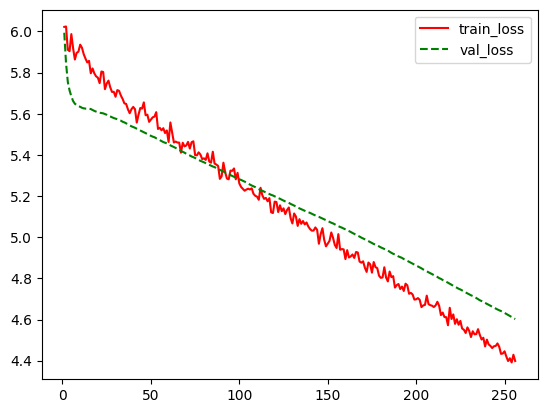

Training and validation accuracy:


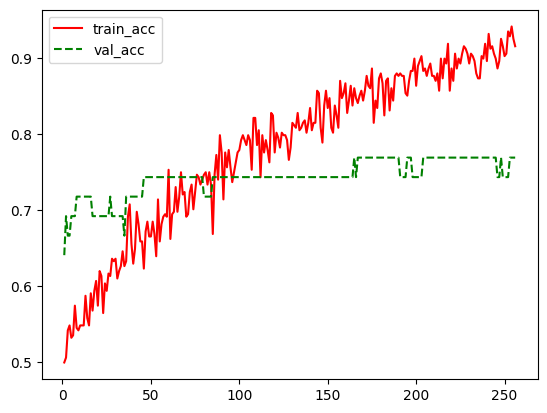

Learning rate:


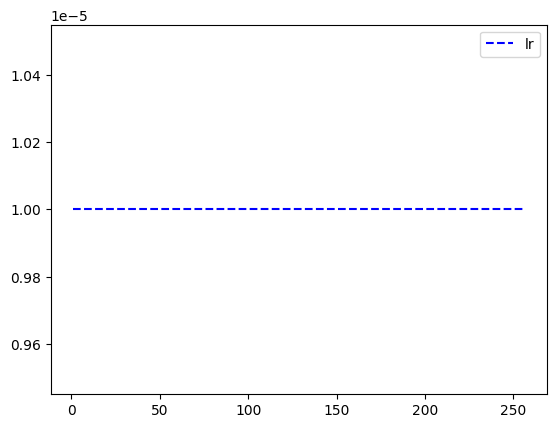

In [ ]:
print("\tEvaluation of the model at the end of training\n")
evaluate_model(H_model)

print("\n\tEvaluation of the model instance at the best point in the training (the highest validation accuracy)\n")
H_model.load_weights(model_filepath)
evaluate_model(H_model)

print("\nThe highest validation accuracy achieved by this model was", np.max(H_history.history['val_acc']))

plot_history(H_history)